# Regressão Logística - Plano de Saúde - dados anonimizados
  Autor: Rogério R R Coelho

O objetivo é identificar os fatores relacionados à evasão (cancelamento) de beneficiários de um plano de saúde e gerar insights que ajudem a reduzir o churn.

📊 Objetivo da Análise

Criar e avaliar um modelo estatístico preditivo capaz de estimar quais beneficiários têm maior risco de evasão nos próximos 12 meses.

📂 Base de Dados (nenhuma descrição adicional sobre os dados foi disponibilizada)

* Id_cliente: Identificação única do cliente
* Titularidade: Se é titular ou dependente do plano
* Cancelado: Status do cliente (Sim/Não)
* Faixa de Renda
* Idade (na adesão)
* Tempo de Plano (meses)
* Sexo
* Quantidade de consultas (últimos 12 meses)
* Quantidade de internações (últimos 12 meses)
* Valor da mensalidade
* UF
* Inadimplente (Sim/Não)

## Etapas
1️⃣ Explorar e limpar os dados: análise exploratória (EDA), tratamento de  valores faltantes e outliers.

2️⃣ Analisar estatisticamente: Calcular a taxa de churn, comparar entre grupos e destacar as variáveis mais relevantes.

3️⃣ Visualizar: gráficos (distribuições, heatmaps, etc.).

4️⃣ Modelar: Criar um modelo preditivo de churn, avalie acurácia e interprete os principais fatores.

5️⃣ Recomendar: Sugestões de ações estratégicas baseadas no que você encontrou.

EDA

Carregar os dados
Arquivo: processo_seletivo_base_churn.xlsx


# Conectar Google Drive ao Google Colab

In [18]:
# Execução no google colab com o arquivo no google dirve

# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# Importar as bibliotecas que serão utilizadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mannwhitneyu
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (precision_score, recall_score, accuracy_score,f1_score, roc_curve, roc_auc_score)
import statsmodels.api as sm # biblioteca para a regressão logística
import statistics
import math
from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Funções para padronizar os resultados e facilitar a análise


In [20]:
def univariada_variavel_numerica(dado, variavel):
    """
    Autor: Mateus Rocha - time ASN.Rocks

    Gera uma matriz de gráficos (2x2) para uma variável contínua.

    [1,1] Histograma
    [1,2] Gráfico de violino
    [2,1] Box plot
    [2,2] Box plot com pontos sobrepostos

    Acima dos gráficos, exibe uma tabela com as estatísticas descritivas da variável.

    Parâmetros:
        dado (pd.DataFrame): Base de dados contendo a variável
        variavel (str): Nome da variável a ser analisada

    Retorna:
        None

    """

    # Calcular as estatísticas descritivas
    desc_stats = dado[variavel].describe().to_frame().T
    desc_stats = desc_stats.round(4)  # Limitar a 4 casas decimais

    # Configuração dos subplots
    fig = plt.figure(figsize=(14, 10))
    fig.suptitle(f"Análise da variável: {variavel}", fontsize=16, y=0.98)

    # Adicionar a tabela no topo
    ax_table = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax_table.axis("off")
    table = ax_table.table(cellText=desc_stats.values,
                           colLabels=desc_stats.columns,
                           rowLabels=desc_stats.index,
                           cellLoc="center",
                           loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(desc_stats.columns))))

    # [1,1] Histograma
    ax1 = plt.subplot2grid((3, 2), (1, 0))
    sns.histplot(dado[variavel], kde=True, ax=ax1, color="skyblue")
    ax1.set_title("Histograma", fontsize=12)
    ax1.set_xlabel(variavel)

    # [1,2] Gráfico de violino
    ax2 = plt.subplot2grid((3, 2), (1, 1), sharex=ax1)
    sns.violinplot(x=dado[variavel], ax=ax2, color="lightgreen")
    ax2.set_title("Gráfico de violino", fontsize=12)
    ax2.set_xlabel(variavel)

    # [2,1] Box plot
    ax3 = plt.subplot2grid((3, 2), (2, 0), sharex=ax1)
    sns.boxplot(x=dado[variavel], ax=ax3, color="orange")
    ax3.set_title("Box plot", fontsize=12)
    ax3.set_xlabel(variavel)

    # [2,2] Box plot com pontos sobrepostos
    ax4 = plt.subplot2grid((3, 2), (2, 1), sharex=ax1)
    sns.boxplot(x=dado[variavel], ax=ax4, color="lightcoral")
    sns.stripplot(x=dado[variavel], ax=ax4, color="black", alpha=0.5, jitter=True)
    ax4.set_title("Box plot com pontos", fontsize=12)
    ax4.set_xlabel(variavel)

    # Ajustes finais
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def univariada_variavel_categoria(dado, variavel):
    """
    Autor: Mateus Rocha - time ASN.Rocks

    Análises para variáveis categóricas.

    1. Retorna o describe transposto e formatado em uma tabela.
    2. Retorna uma tabela com a frequência de cada nível (incluindo percentuais e total).
    3. Plota um gráfico de barras com a frequência e exibe os valores no topo.

    Parâmetros:
        dado (pd.DataFrame): O dataframe contendo os dados.
        variavel (str): O nome da variável categórica para análise.

    Retorna:
        None

    Exemplo de uso:
        >>> import pandas as pd
        >>> df = pd.DataFrame({'Categoria': ['A', 'B', 'A', 'C', 'B', 'A', 'C', 'C', 'A', 'B']})
        >>> univariada_variavel_categoria(df, 'Categoria')
    """
    # Verificar se a variável está no DataFrame
    if variavel not in dado.columns:
        raise ValueError(f"A variável '{variavel}' não está no DataFrame.")

    # 1. Describe transposto e formatado
    describe_table = dado[variavel].describe().to_frame()
    describe_table = describe_table.T
    describe_table.index = [variavel]

    # Exibir a tabela formatada
    print("Describe da variável categórica:")
    display(describe_table)

    # 2. Frequência de cada nível (com percentuais e total)
    frequency_table = dado[variavel].value_counts().reset_index()
    frequency_table.columns = [variavel, 'Frequência']
    frequency_table['Percentual (%)'] = (frequency_table['Frequência'] / len(dado) * 100).round(2)

    # Adicionar uma linha para o total
    total_row = pd.DataFrame({
        variavel: ['Total'],
        'Frequência': [frequency_table['Frequência'].sum()],
        'Percentual (%)': [100.0]
    })
    frequency_table = pd.concat([frequency_table, total_row], ignore_index=True)

    # Exibir a tabela formatada
    print("Tabela de frequência da variável categórica (com percentuais e total):")
    display(frequency_table)

    # 3. Gráfico de barras com frequência
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=variavel, y='Frequência', data=frequency_table[:-1], errorbar=None)

    # Adicionar os valores no topo das barras
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

    # Configurar o gráfico
    plt.title(f'Gráfico de Frequência: {variavel}')
    plt.xlabel(variavel)
    plt.ylabel('Frequência')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analise_var_numerica_por_percentil_2(data, x, y, q=10, grafico='none'):
    """
    Autor: Mateus Rocha - time ASN.Rocks
    (modificara - rcoelho)

    Ordena a variável x, divide em percentis e sumariza estatísticas.

    Parâmetros:
        data (pd.DataFrame): O banco de dados contendo as variáveis.
        x (str): O nome da variável independente (explanatória).
        y (str): O nome da variável dependente (resposta).
        q (int): O número de percentis (default: 10).
        grafico (str): Opção de gráfico: 'p', 'logito', 'ambos', 'none' (default: 'none').

    Retorno:
        pd.DataFrame: DataFrame com as estatísticas por percentil, incluindo:
                      - Percentil
                      - n (número de linhas)
                      - Min de x
                      - Max de x
                      - p (média de y)
                      - logito de p
    """
    # Certificar-se de que a variável y está no formato numérico
    data[y] = pd.to_numeric(data[y], errors='coerce')

    # Ordenar os dados pela variável x
    data = data.sort_values(by=x).reset_index(drop=True)

    # Criar os percentis com duplicatas descartadas
    percentil_series, bins = pd.qcut(data[x], q=q, retbins=True, duplicates='drop')

    # Atualiza o número real de bins
    num_bins = len(bins) - 1

    # Criar labels dinamicamente com base no número real de bins
    labels = [str(i) for i in range(1, num_bins + 1)]

    # Aplicar novamente o qcut com os labels corretos
    data['percentil'] = pd.qcut(data[x], q=q, labels=labels, duplicates='drop')

    # Sumarizar as estatísticas por percentil
    summary = data.groupby('percentil').agg(
        n=(x, 'count'),
        min_x=(x, 'min'),
        max_x=(x, 'max'),
        p=(y, 'mean')
    ).reset_index()

    # Calcular o logito de p com ajuste para evitar divisão por zero
    epsilon = 1e-10
    p_clipped = np.clip(summary['p'], epsilon, 1 - epsilon)
    summary['logito_p'] = np.log(p_clipped / (1 - p_clipped))

    # Opções de gráfico
    if grafico in ['p', 'logito', 'ambos']:
        plt.figure(figsize=(12, 6))

        if grafico == 'p':
            plt.scatter(summary['percentil'], summary['p'], color='blue')
            plt.title('Gráfico de Percentil x p')
            plt.xlabel('Percentil')
            plt.ylabel('p (média de y)')
            plt.grid(True)
            plt.show()

        elif grafico == 'logito':
            plt.scatter(summary['percentil'], summary['logito_p'], color='red')
            plt.title('Gráfico de Percentil x Logito de p')
            plt.xlabel('Percentil')
            plt.ylabel('Logito de p')
            plt.grid(True)
            plt.show()

        elif grafico == 'ambos':
            fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

            axes[0].scatter(summary['percentil'], summary['p'], color='blue')
            axes[0].set_title('Percentil x p')
            axes[0].set_xlabel('Percentil')
            axes[0].set_ylabel('p (média de y)')
            axes[0].grid(True)

            axes[1].scatter(summary['percentil'], summary['logito_p'], color='red')
            axes[1].set_title('Percentil x Logito de p')
            axes[1].set_xlabel('Percentil')
            axes[1].set_ylabel('Logito de p')
            axes[1].grid(True)

            plt.tight_layout()
            plt.show()

    return summary

# Leitura dos Dados

In [21]:
# Carregar os dados usando google colab e google drive
# df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/churn/base_churn.xlsx')

# Rodando localmente 
df = pd.read_excel('base_churn.xlsx')
# Visualizar as primeiras linhas
df.head()

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE
0,53100,TITULAR,NÃO,Média renda,39,302,F,RJ,NÃO,12,1,1030.0
1,140400,TITULAR,NÃO,Média renda,24,307,F,BA,NÃO,4,0,720.0
2,105059,TITULAR,NÃO,Média renda,1,295,M,MG,NÃO,6,7,NaN
3,82963,TITULAR,NÃO,Média renda,36,294,M,RJ,NÃO,21,1,1030.0
4,97768,TITULAR,SIM,Baixa renda,20,259,F,RN,NÃO,30,0,550.0


In [22]:
# removendo a coluna ID_CLIENTE, pois não tem utilidade alguma na análise nem na construção do modelo
df = df.drop(columns=['ID_CLIENTE'],axis=1)

# Informações gerais
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101063 entries, 0 to 101062
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   TITULARIDADE          101063 non-null  object 
 1   CANCELADO             101063 non-null  object 
 2   FAIXA_RENDA           101063 non-null  object 
 3   IDADENAADESÃO         101063 non-null  int64  
 4   TEMPO_DE_PLANO_MESES  101063 non-null  int64  
 5   SEXO                  99069 non-null   object 
 6   UF                    99027 non-null   object 
 7   INADIMPLENTE          101063 non-null  object 
 8   QTD_CONSULTAS_12M     101063 non-null  int64  
 9   QTD_INTERNACOES_12M   101063 non-null  int64  
 10  VALOR_MENSALIDADE     63861 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 8.5+ MB


,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE
count,101063.000000,101063.000000,101063.000000,101063.000000,63861.000000
mean,30.868755,258.845047,12.099354,1.303326,916.413774
std,27.656371,50.268563,10.769351,1.295004,396.843048
min,-19.000000,-22.000000,1.000000,0.000000,550.000000
25%,12.000000,221.000000,5.000000,1.000000,550.000000
50%,29.000000,281.000000,9.000000,1.000000,720.000000
75%,42.000000,301.000000,15.000000,2.000000,1030.000000
max,249.000000,311.000000,60.000000,9.000000,1870.000000


# Cálculo do percentual de nulos de cada coluna

In [23]:
# Percentual de valores nulos por coluna
percentual_nulos = df.isnull().mean() * 100

# Exibir resultado ordenado do maior para o menor
percentual_nulos.sort_values(ascending=False)


VALOR_MENSALIDADE       36.810702
UF                       2.014585
SEXO                     1.973027
FAIXA_RENDA              0.000000
CANCELADO                0.000000
TITULARIDADE             0.000000
TEMPO_DE_PLANO_MESES     0.000000
IDADENAADESÃO            0.000000
INADIMPLENTE             0.000000
QTD_CONSULTAS_12M        0.000000
QTD_INTERNACOES_12M      0.000000
dtype: float64

**Percentual de dados ausentes encontrados.**
*   VALOR_MENSALIDAD (36.81%)
*   UF (2.01%)
*   SEXO (1.97%)

(definir uma abordagem de tratamento)

# Exploração das Variáveis

# Variável: Titularidade

Describe da variável categórica:


,count,unique,top,freq
TITULARIDADE,101063,2,TITULAR,101062


Tabela de frequência da variável categórica (com percentuais e total):


,TITULARIDADE,Frequência,Percentual (%)
0,TITULAR,101062,100.0
1,DEPENDENTE,1,0.0
2,Total,101063,100.0


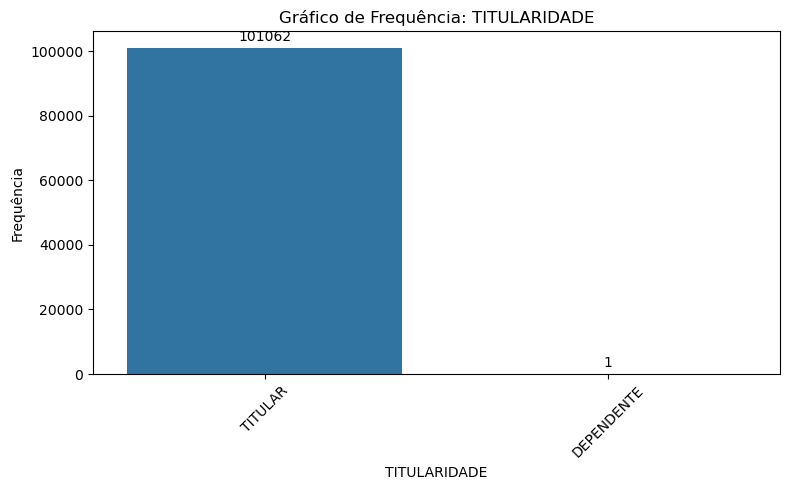

In [24]:
univariada_variavel_categoria(df, 'TITULARIDADE')

Variável quase constante (com apenas um valor diferente em mais de 100 mil): não oferece poder explicativo para o modelo.

Problemas Potenciais:
* podem gerar problemas de convergência do modelo.
* overfitting

**Remover a variável / não utilizá-la na modelagem**

# Variável: Cancelado (variável resposta)

Describe da variável categórica:


,count,unique,top,freq
CANCELADO,101063,2,SIM,59441


Tabela de frequência da variável categórica (com percentuais e total):


,CANCELADO,Frequência,Percentual (%)
0,SIM,59441,58.82
1,NAO,41622,41.18
2,Total,101063,100.00


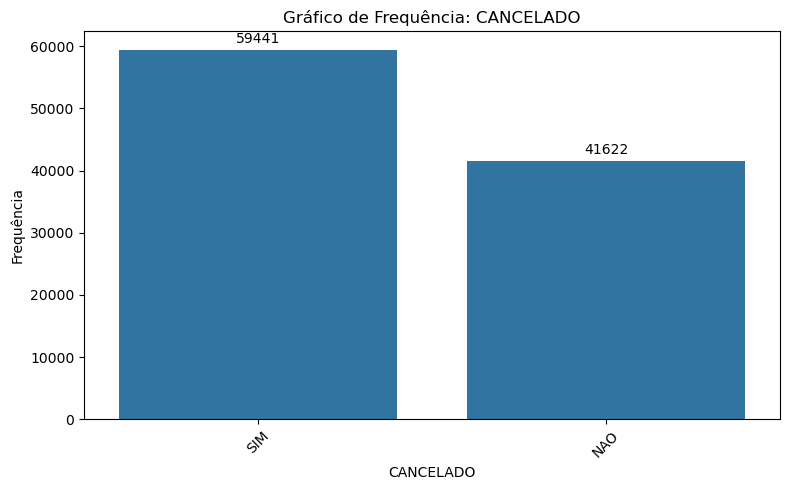

In [25]:
# padroniza a variável
df['CANCELADO'] = (
    df['CANCELADO'].str.strip().str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
)
univariada_variavel_categoria(df, 'CANCELADO')

O mais frequente é o cancelamento com 58.8% de cancelamentos.
Não existem dados ausentes o que é bom, pois caso existisse teríamos que remover as ocorrencias.

# Variável: FAIXA_RENDA

Describe da variável categórica:


,count,unique,top,freq
FAIXA_RENDA,101063,3,Baixa renda,65001


Tabela de frequência da variável categórica (com percentuais e total):


,FAIXA_RENDA,Frequência,Percentual (%)
0,Baixa renda,65001,64.32
1,Média renda,24910,24.65
2,Alta renda,11152,11.03
3,Total,101063,100.00


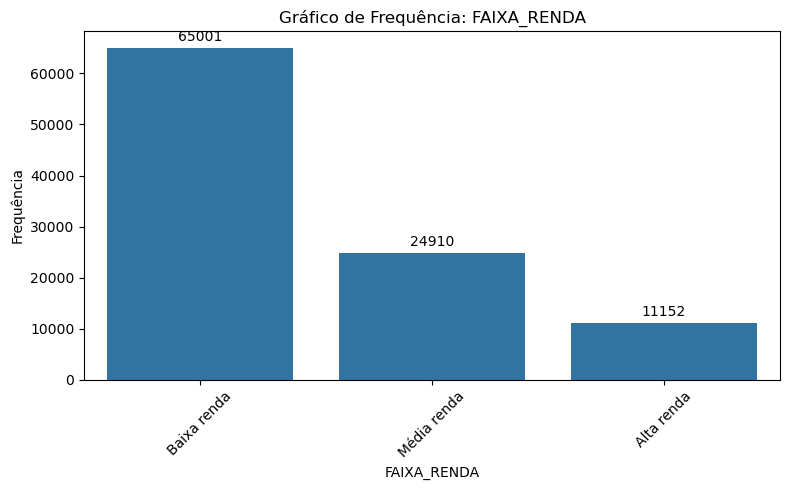

In [26]:
univariada_variavel_categoria(df, 'FAIXA_RENDA')

# Variável: Idade na Adesão

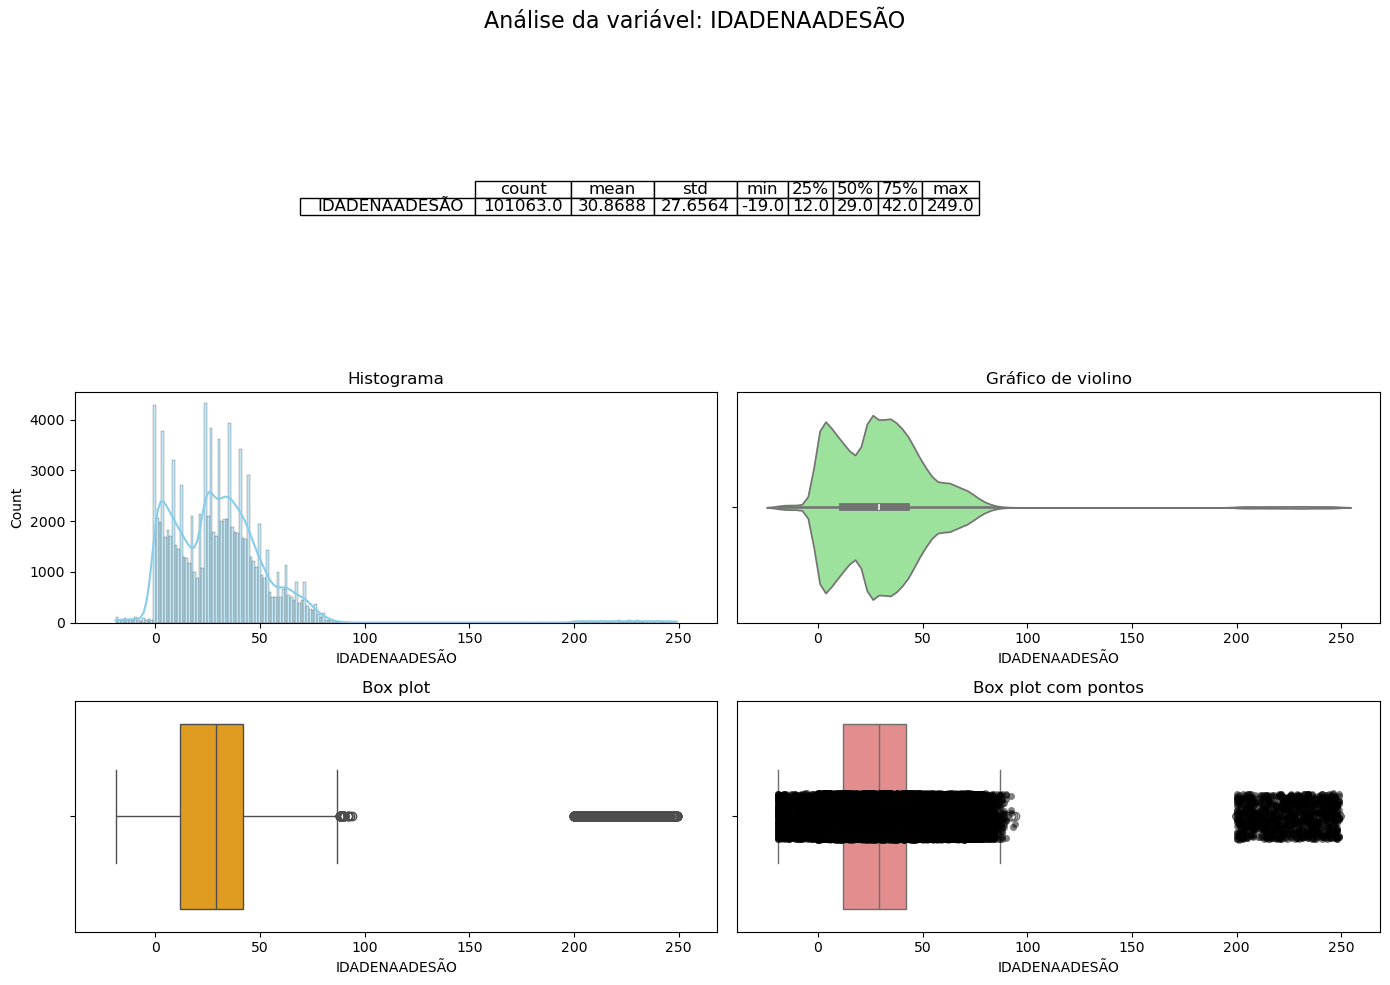

In [27]:
univariada_variavel_numerica(df, 'IDADENAADESÃO')

Histograma: Mostra grande concentração de valores entre 0 e 60, com poucos valores acima de 60 - cauda longa direita.
**Existem valores negativos e um pequeno número de valores muito altos que fogem do padrão principal da distribuição.**

Violino: densidade bimodal, com maior concentração na faixa menor que 50 e um alongamento para valores mais altos.

Boxplot: presença de muitos outliers, tanto negativos quanto positivos (acima de 150).
Reflete claramente a dispersão dos dados e a presença de vários pontos fora dos limites normais, especialmente em valores altos e negativos.

**Qualidade dos Dados**
* Valores Negativos: devem ser descartados, pois são impossíveis como idade de adesão.

* Valores Acima de 150: devem ser descartados, pois são improváveis ou são erros de cadastro.

A variável apresenta forte assimetria e outliers.

**Importante uma conversar com a área de negócios, área de dados, área de cadastro ou área que gerou os dados para confirmar o cenário existente e também para confirmar o corte sugerido: valores negativos e acima de 150.**


# Variável: TEMPO_DE_PLANO_MESES

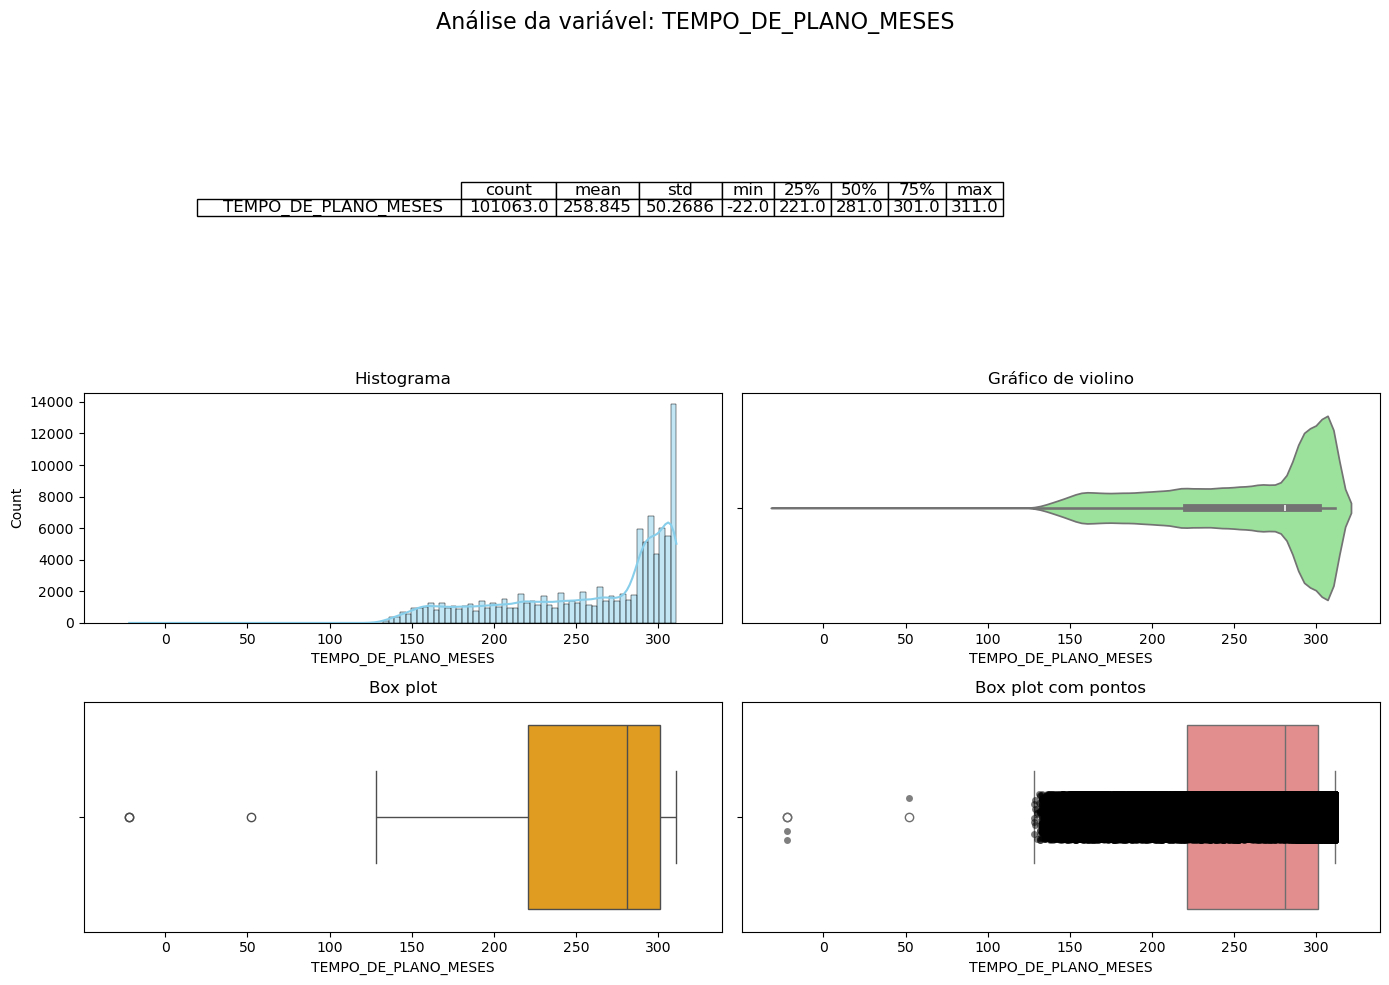

In [28]:
univariada_variavel_numerica(df, 'TEMPO_DE_PLANO_MESES')

Histograma: distribuição assimétrica, com grande concentração de registros entre 220 e 311 meses.

Gráfico de Violino: Reflete a densidade concentrada nas faixas mais altas, com pequena dispersão para valores menores.

Boxplot: grupo principal de valores em uma faixa relativamente estreita, mas com presença de outliers (incluindo valores negativos).

Boxplot: grande volume de dados no intervalo dos quartis e evidencia de outliers (principalmente abaixo de 150 e negativos).

**Valores Negativos: descartar, pois correspondem a erros de cadastro e não têm sentido prático.**

Predomínio de Planos Antigos: A maioria dos participantes tem tempo de plano muito alto (mais de 18 anos — acima de 220 meses), indicando uma base com predominio de contratos antigos.

**O contato com outras áreas como sinalizado anteriormente para alinhar com as áreas responsáveis sobre possíveis causas de erro e validação do tratamento aplicado.**

# Variável: Sexo

Describe da variável categórica:


,count,unique,top,freq
SEXO,99069,2,F,56480


Tabela de frequência da variável categórica (com percentuais e total):


,SEXO,Frequência,Percentual (%)
0,F,56480,55.89
1,M,42589,42.14
2,Total,99069,100.00


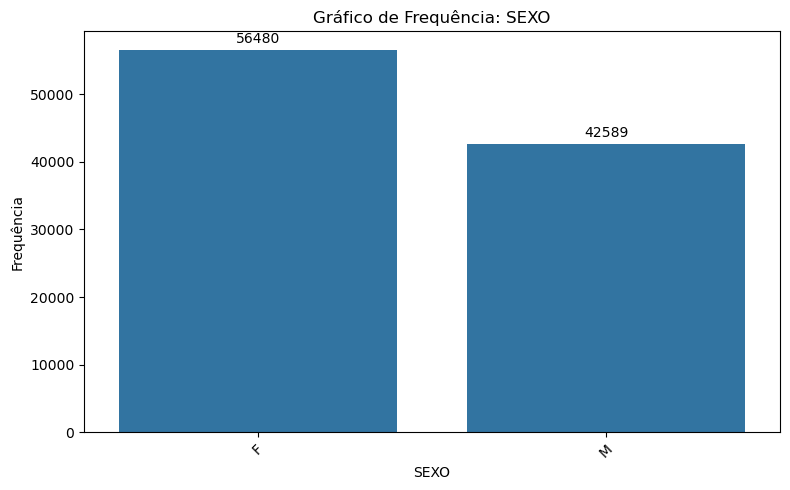

In [29]:
univariada_variavel_categoria(df,'SEXO')

Predomínio do sexo biologico feminino
2% de dados ausentes conforme visto inicialmente

# Variável: UF

Describe da variável categórica:


,count,unique,top,freq
UF,99027,27,SP,16228


Tabela de frequência da variável categórica (com percentuais e total):


,UF,Frequência,Percentual (%)
0,SP,16228,16.06
1,RJ,15077,14.92
2,BA,12759,12.62
3,MG,9654,9.55
4,DF,6707,6.64
5,MA,5106,5.05
6,PE,5044,4.99
7,RS,4178,4.13
8,PR,2918,2.89
9,SE,2727,2.70


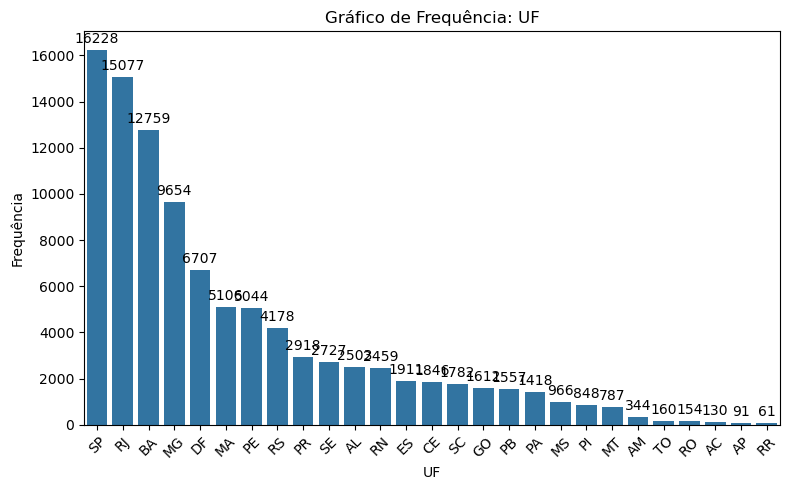

In [30]:
univariada_variavel_categoria(df, 'UF')

Maior concentração nos estados: SP, RJ, BA e MG

2% de dados ausentes conforme visto inicialmente

# Mapeamento por regiões

Describe da variável categórica:


,count,unique,top,freq
regiao,99027,5,Sudeste,42870


Tabela de frequência da variável categórica (com percentuais e total):


,regiao,Frequência,Percentual (%)
0,Sudeste,42870,42.42
1,Nordeste,34849,34.48
2,Centro-Oeste,10072,9.97
3,Sul,8878,8.78
4,Norte,2358,2.33
5,Total,99027,100.00


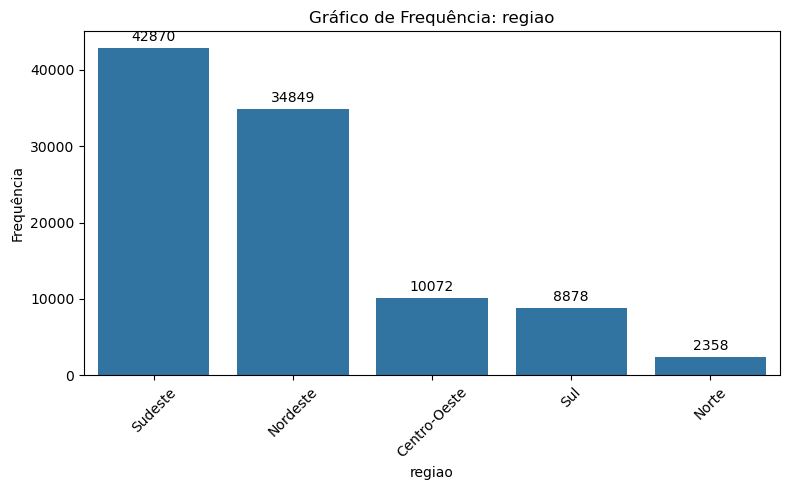

In [31]:
# Dicionário de regiões por UF
regioes_uf = {
    # Norte
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    # Nordeste
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste',
    'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    # Centro-Oeste
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    # Sudeste
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    # Sul
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# Criar a coluna regiao usando o mapeamento. Usa str.upper para garantir maiúsculas.
df['regiao'] = df['UF'].str.upper().map(regioes_uf)

univariada_variavel_categoria(df, 'regiao')

A maioria dos clientes (76.9%) estão nas regiões sudeste e nordeste

# Variável: INADIMPLENTE

Describe da variável categórica:


,count,unique,top,freq
INADIMPLENTE,101063,2,NÃO,73948


Tabela de frequência da variável categórica (com percentuais e total):


,INADIMPLENTE,Frequência,Percentual (%)
0,NÃO,73948,73.17
1,SIM,27115,26.83
2,Total,101063,100.00


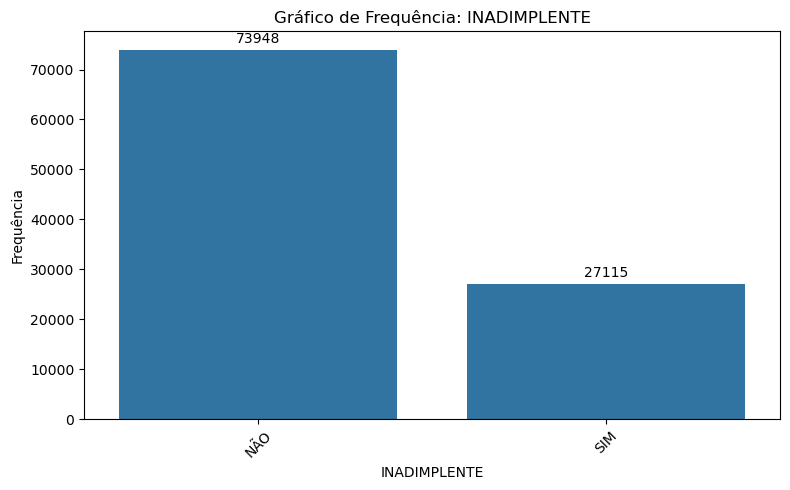

In [32]:
univariada_variavel_categoria(df, 'INADIMPLENTE')

A variável nos mostra um percentual alto de inadimplentes (27%), seria importante uma conversa com a área de negócios para saber se este valor está deacordo com o benchmark de mercado (saber se o valor está acima do padrão do setor ou não).

# Variável: QTD_CONSULTAS_12M
Quantidade de consultas nos últimos 12 meses



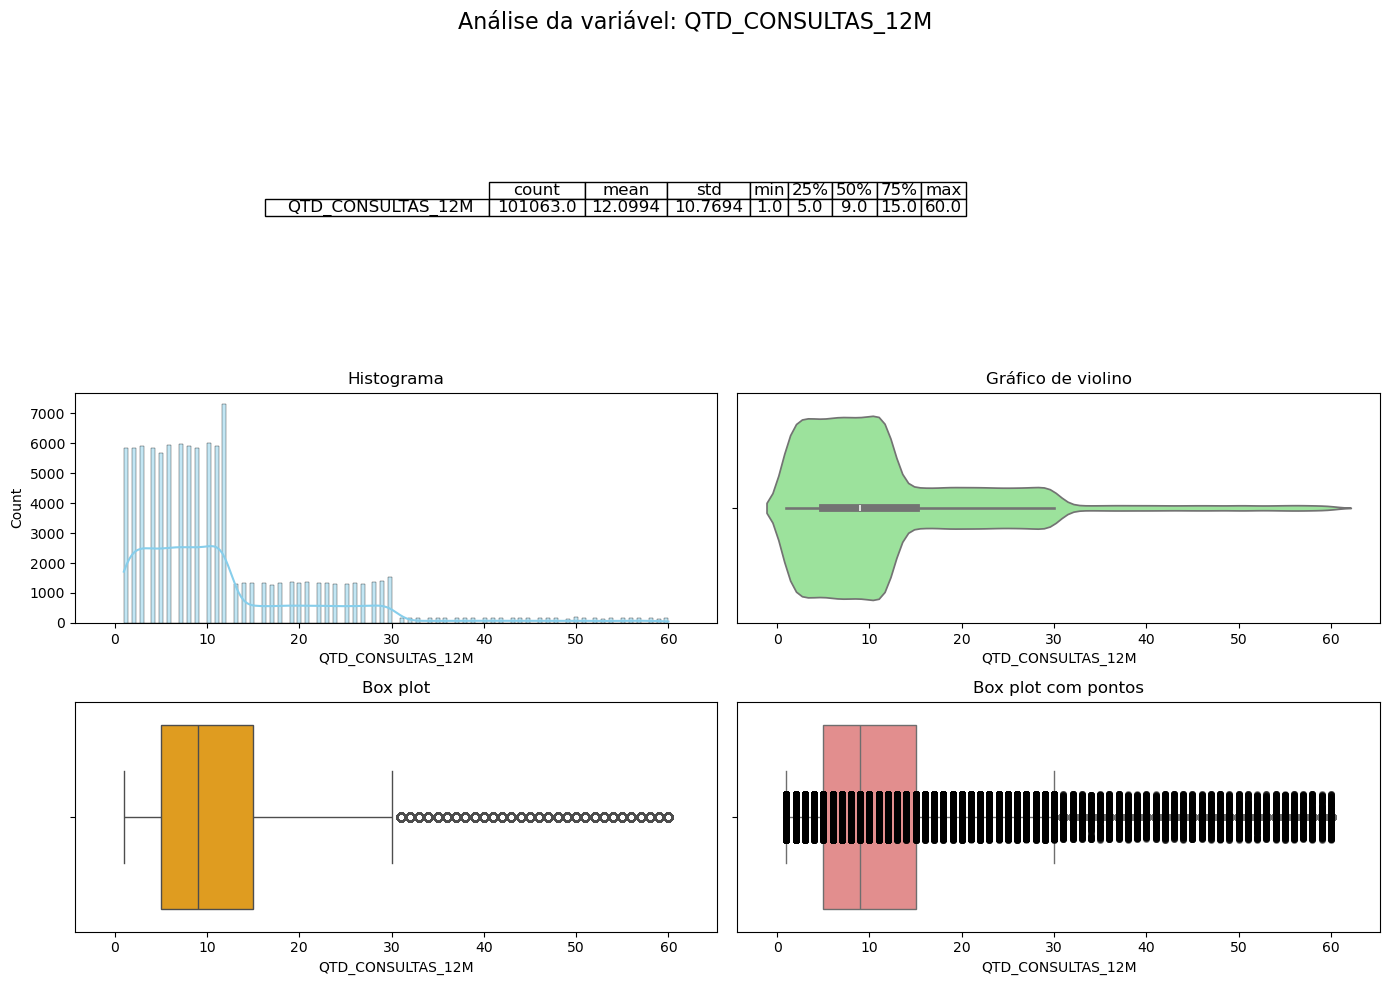

In [33]:
univariada_variavel_numerica(df, 'QTD_CONSULTAS_12M')

Histograma: distribuição assimétrica positiva, com alta frequência de valores entre 1 e 15 e poucos valores acima de 30. A maior parte dos dados está concentrada abaixo de 15 consultas, com cauda longa para valores elevados.

Violino: Confirma a densidade mais alta para os menores valores. Gráfico achatado e estendido para a direita mostra a presença de outliers e forte assimetria.

Boxplot: muitos valores atípicos (outliers) acima de 30. O boxplot clássico reforça a dispersão dos dados e concentração até o terceiro quartil, com pontos destoantes no extremo superior. O boxplot com pontos demonstra a quantidade de outliers de forma individual.

A Distribuição não segue a distribuição normal, é positivamente assimétrica (cauda longa à direita).

Embora a média seja 12 consultas, há usuários com uso bastante elevado. A maioria faz menos de 15 consultas/ano, com a mediana em 9.

O desvio padrão alto mostra grande variabilidade no número de consultas.

Ponto de atenção: alta concentração de valores baixos e a existência de uma minoria com uso elevado.


# Variável: QTD_INTERNACOES_12M
Quantidade de internações nos últimos 12 meses

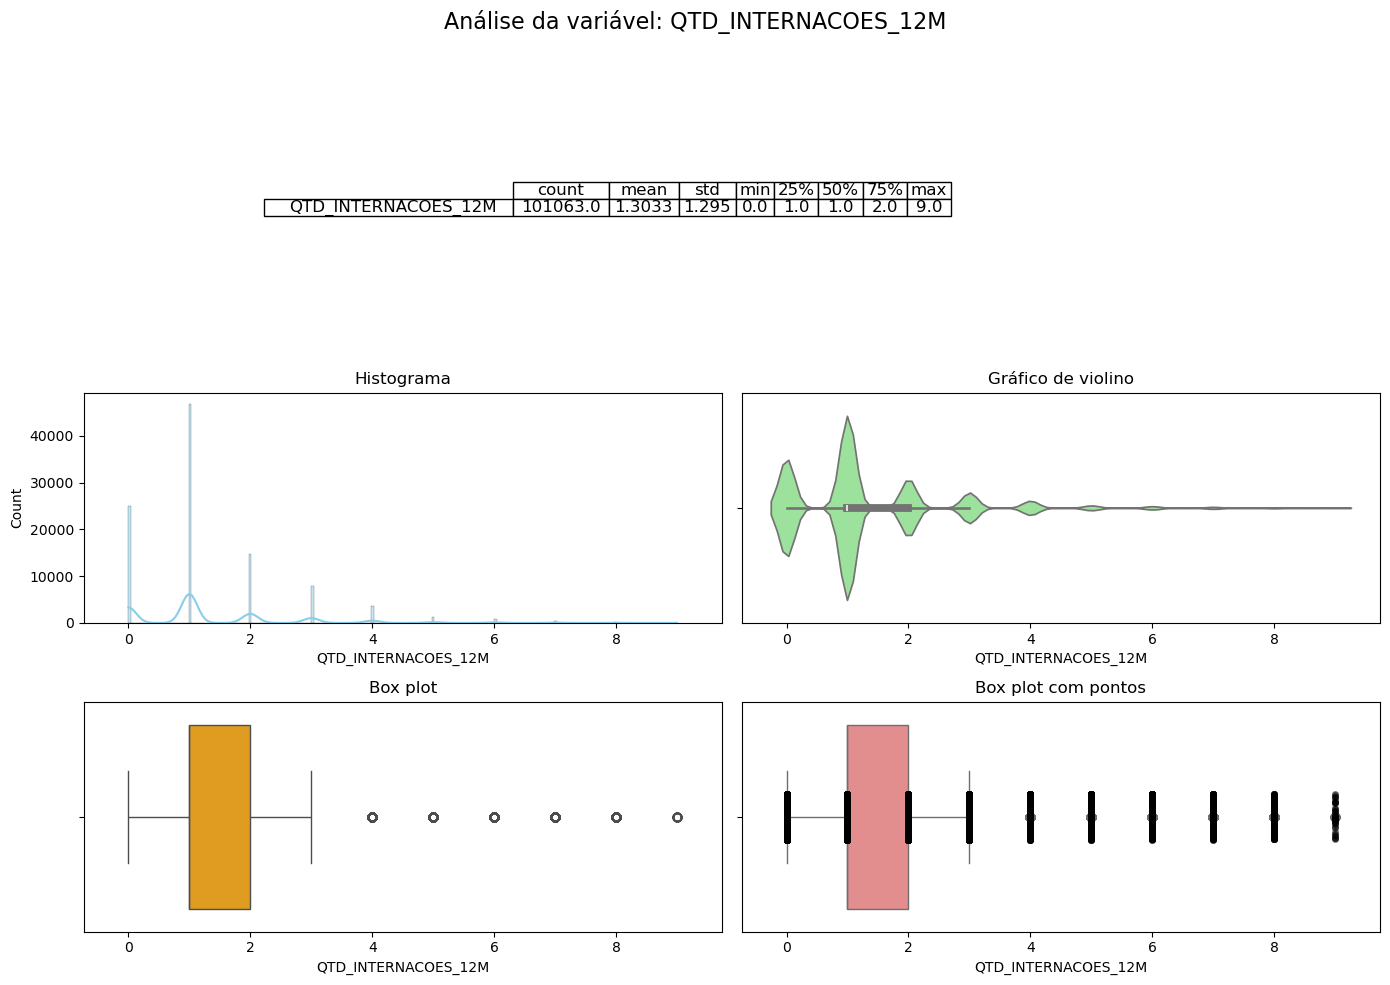

In [34]:
univariada_variavel_numerica(df, 'QTD_INTERNACOES_12M')

Histograma: Distribuição muito concentrada em zero, um e dois eventos. Alta frequência nos menores valores e com declínio rápido para eventos mais altos. Poucos usuários com mais de 2 internações ao longo do ano.

Violino: Reflete alta densidade para os menores valores, e raridade de internações mais frequentes.

Forte assimetria positiva.

Boxplots: concentração de dados no baixo número de internações. O boxplot com pontos mostra a quantidade restrita desses casos extremos.

A maioria esmagadora dos clientes tem poucas ou nenhuma internação no período de 12 meses. Mediana e 25%/75% muito próximas (todas ≤ 2).

Outliers: valor máximo de 9 é alto, mas ocorre em pouquíssimos casos.

Desvio padrão próximo da média indicando grande heterogeneidade, porém concentrado nos valores mais baixos.


# Variável: Valor da Mensalidade

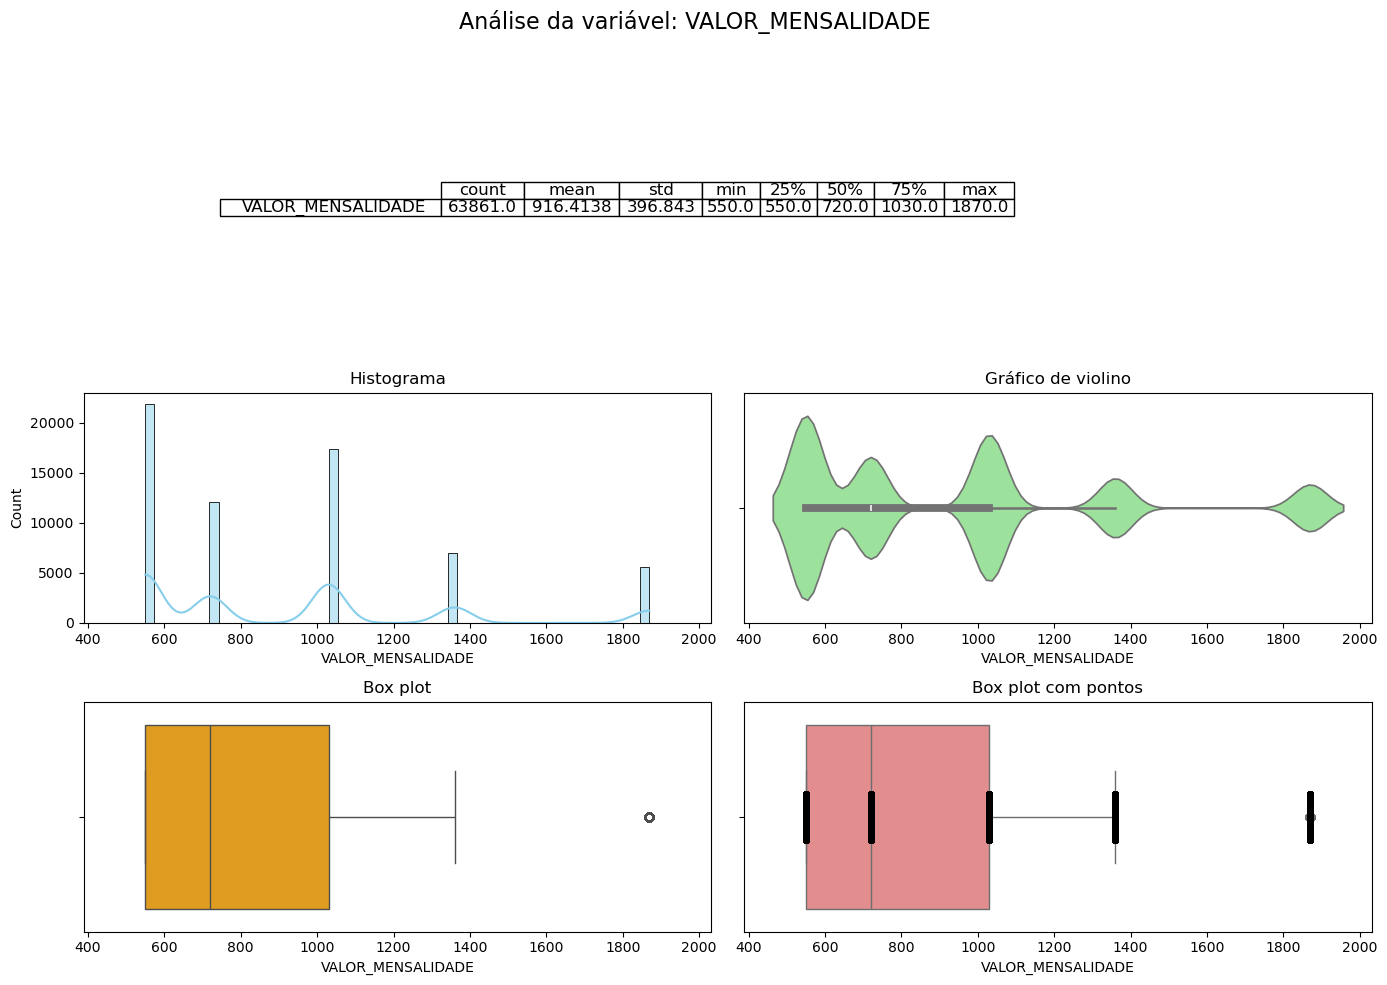

In [35]:
univariada_variavel_numerica(df, 'VALOR_MENSALIDADE')

**Ponto a ser tratado/observado: variável com ausência de dados elevada**

Histograma: distribuição discreta dos valores com picos bem definidos, o que é um indício de planos ou faixas fixas de mensalidade. Por não ser uma curva contínua indica a existencia de produtos ou categorias padronizadas.

Violino: presença de vários picos de densidade.

Boxplot: Indica que a maior parte dos dados está concentrada entre 550 e 1.030, com valores acima desse intervalo sendo menos frequentes.

Pode ser interessante representar essa variável de maneira categórica, agrupando os principais valores em classes (por ser discreta) o que facilitaria também o tratamento dos dados ausentes, criando uma categoria "outros" para representá-los.


# Resumindo as observações sobre a análise univariada

* **TITULARIDADE**: Remover a variável / não utilizá-la na modelagem
* **IDADENAADESÃO**:


1.   Negativos: devem ser descartados, pois são impossíveis como idade de adesão.
2.   Valores Acima de 150: devem ser descartados, pois são muito improváveis ou são erros de cadastro.

* **TEMPO_DE_PLANO_MESES**: descartar valores negativos (erros de cadastro).

* UF: 2% dados ausentes (imputar valores ausentes - pendente definir)

* VALOR_MENSALIDADE: dados ausentes elevado (possibilidade de categorizar)

**Importante uma conversar com a área de negócios, área de dados, área de cadastro ou área que gerou os dados para confirmar os cenários existentes e também para confirmar os cortes e alterações sinalizados.**





# Analise Bivariada

Entender a relação das variáveis com a variável resposta (CANCELADO)



# Verificando a correlação entre as variáveis numéricas

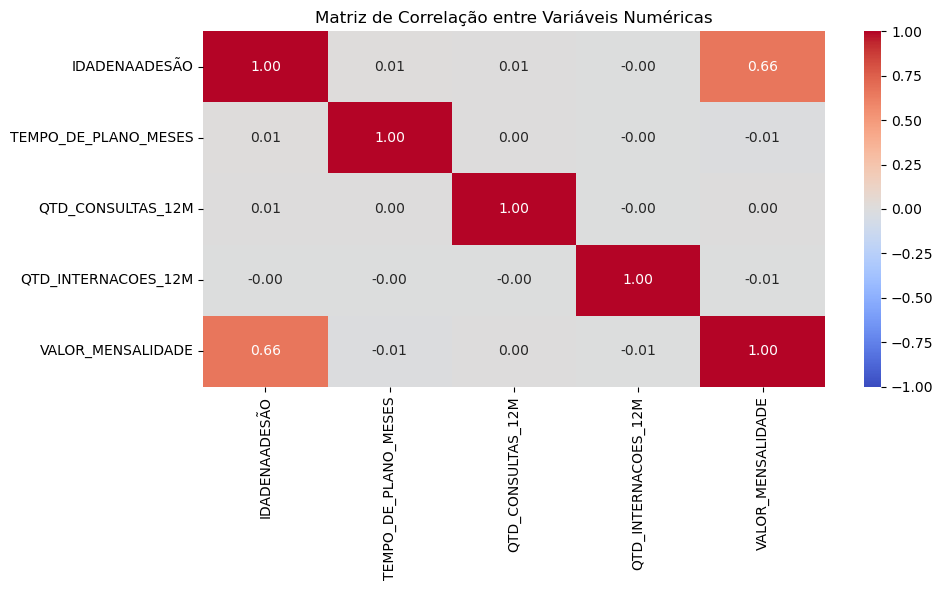

In [36]:
# Selecionando apenas as colunas numéricas
variaveis_numericas = df.select_dtypes(include=['int64', 'float64'])

# Calculando a matriz de correlação (colinearidade)
matriz_correlacao = variaveis_numericas.corr()

# Exibindo a matriz de correlação com heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()


Nada que indique uma preocupação, nenhum valor muito elevado (acima de 0.75)

# Bivariada: Cancelado x Valor da Mensalidade x Faixa de Renda

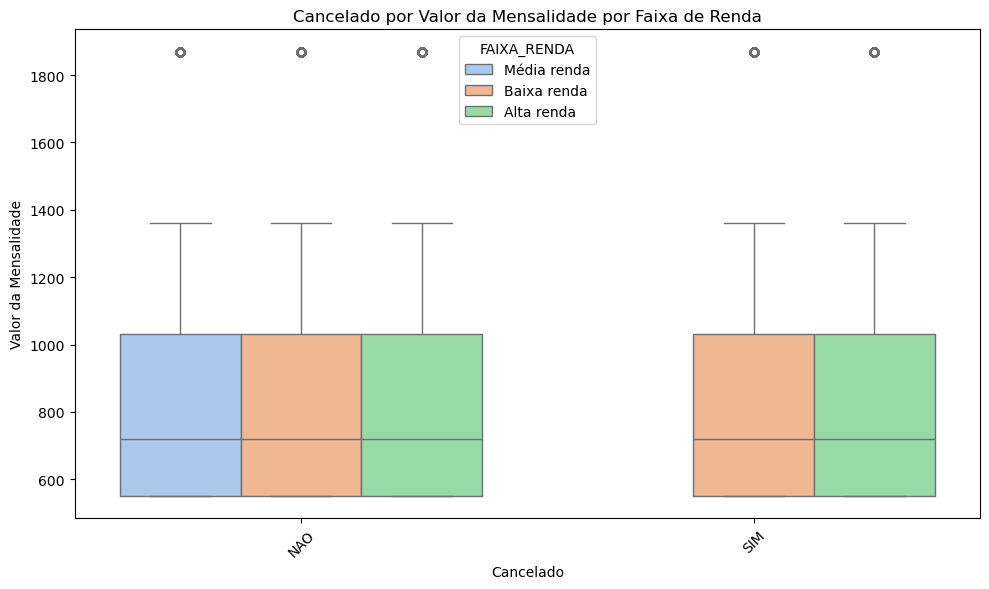

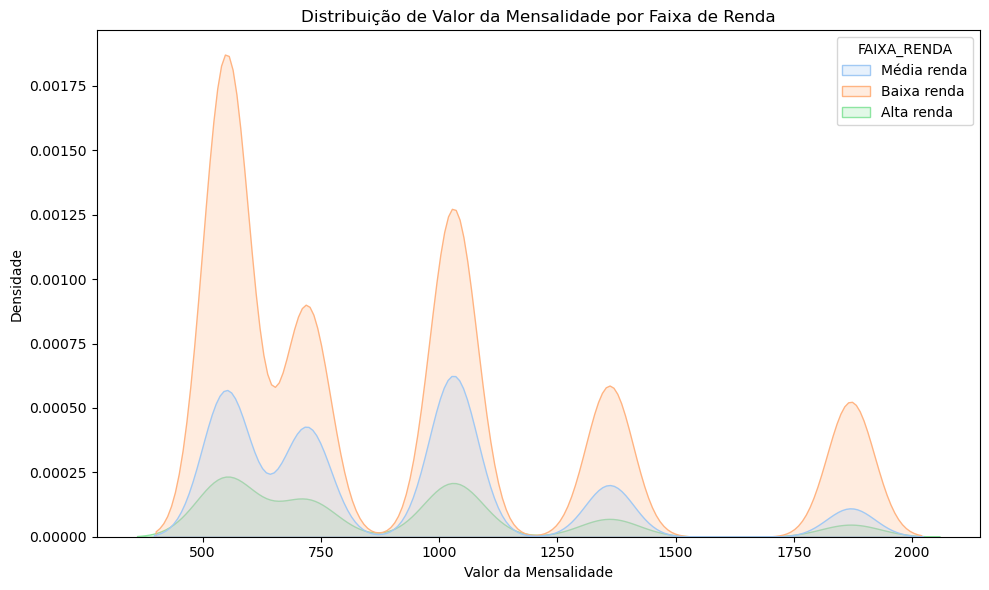

In [37]:
# Boxplot: mensalidade por faixa de renda
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='CANCELADO', y='VALOR_MENSALIDADE', hue='FAIXA_RENDA', palette='pastel', legend=True)

plt.title('Cancelado por Valor da Mensalidade por Faixa de Renda')
plt.ylabel('Valor da Mensalidade')
plt.xlabel('Cancelado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df,
    x='VALOR_MENSALIDADE',
    hue='FAIXA_RENDA',
    fill=True,
    palette='pastel'
)

plt.title('Distribuição de Valor da Mensalidade por Faixa de Renda')
plt.xlabel('Valor da Mensalidade')
plt.ylabel('Densidade')
plt.tight_layout()
plt.show()


In [38]:
# Remover valores ausentes na coluna 'VALOR_MENSALIDADE'
df_valid = df.dropna(subset=['VALOR_MENSALIDADE'])

# Separar os grupos
grupo_cancelado = df_valid[df_valid['CANCELADO'] == 'SIM']['VALOR_MENSALIDADE']
grupo_nao_cancelado = df_valid[df_valid['CANCELADO'] == 'NAO']['VALOR_MENSALIDADE']

# Teste de Mann-Whitney
stat, p_value = mannwhitneyu(grupo_cancelado, grupo_nao_cancelado, alternative='greater')

print(f'Estatística de teste: {stat}')
print(f'Valor-p: {p_value}')


Estatística de teste: 486730827.0
Valor-p: 0.9995136166465105


Hipóteses do teste Mann-Whitney
* H0 (nula): A distribuição dos valores de VALOR_MENSALIDADE dos clientes que cancelaram é menor ou igual à dos que não cancelaram.

* H1 (alternativa): A distribuição dos valores de VALOR_MENSALIDADE dos clientes que cancelaram é maior do que a dos que não cancelaram.

O resultado do p-valor foi muito maior que 0.05, com isso, não rejeitamos H0 em favor de H1.
**Isso significa que a distribuição dos valores de mensalidade dos clientes cancelados é igual ou menor que a dos não cancelados.**

O teste é estatisticamente válido, mas como os valores são discretos e repetidos, haverá muitos empates e isso reduz a sensibilidade do teste — ele pode não detectar diferenças sutis entre as distribuições, mesmo que existam.

O valor-p de 0.998 sugere nenhuma diferença detectada, mas isso pode ser também reflexo da baixa variabilidade real entre os grupos.

Verificar com qui-quadrado categorizando o valor da mensalidade uma vez que é discreto gerando poucos níveis.

In [39]:
# Converter VALOR_MENSALIDADE em string (categórica)
df['VALOR_MENSALIDADE_CAT'] = df['VALOR_MENSALIDADE'].astype(str)

# Tabela de contingência entre valor da mensalidade e cancelamento
contingencia = pd.crosstab(df['VALOR_MENSALIDADE_CAT'], df['CANCELADO'])
print(contingencia)

from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingencia)

print(f"\nEstatística do qui-quadrado: {chi2:.4f}")
print(f"p-valor: {p:.4f}")
print(f"Graus de liberdade: {dof}")

df = df.drop(columns=['VALOR_MENSALIDADE_CAT'],axis=1)


CANCELADO                NAO    SIM
VALOR_MENSALIDADE_CAT              
1030.0                  8484   8891
1360.0                  2719   4296
1870.0                  1438   4116
550.0                   7797  14084
720.0                   5880   6156
nan                    15304  21898

Estatística do qui-quadrado: 1543.0428
p-valor: 0.0000
Graus de liberdade: 5


O p-valor muito baixo (0.0000, ou seja, menor que 0.05) indica que existe associação estatisticamente significativa entre as categorias de valor de mensalidade e o fato do cliente estar cancelado ou não.

**O valor da mensalidade está relacionado ao cancelamento: Clientes de diferentes faixas de valor de mensalidade têm diferentes taxas de cancelamento.**

# Bivariada: Cancelamento (Churn)

# Churn por UF

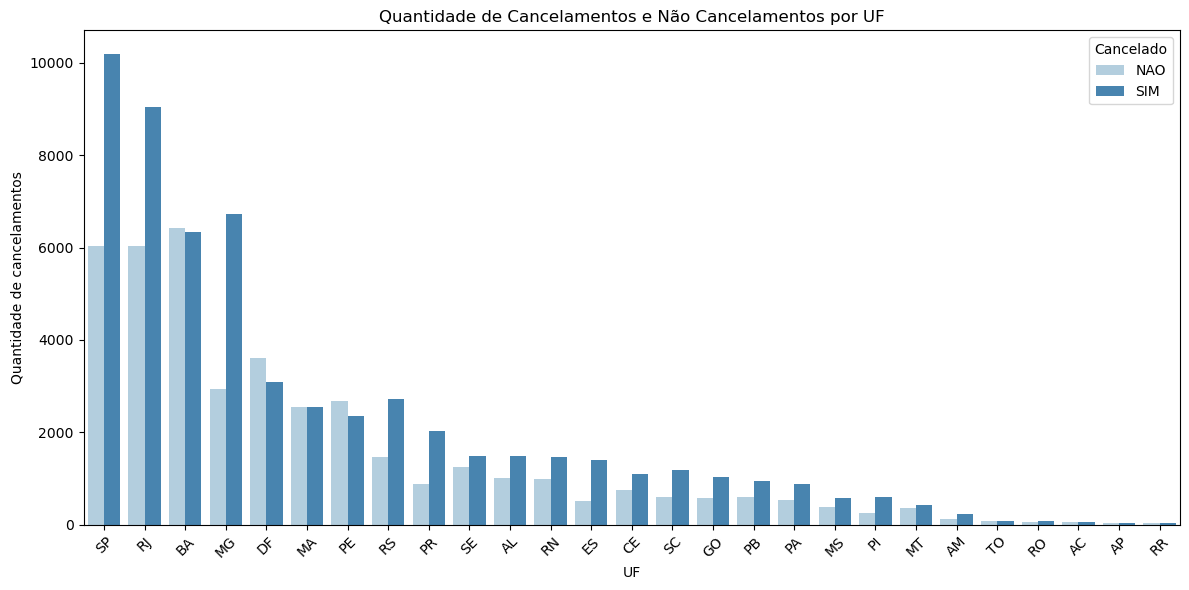

In [40]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='UF', hue='CANCELADO', order=df['UF'].value_counts().index, palette='Blues')

plt.title('Quantidade de Cancelamentos e Não Cancelamentos por UF')
plt.xlabel('UF')
plt.ylabel('Quantidade de cancelamentos')
plt.xticks(rotation=45)
plt.legend(title='Cancelado')
plt.tight_layout()
plt.show()

O gráfico nos mostra que as UFs estão apresentado número de cancelamentos superiores aos clientes ativos na maioria das UFs. Isto pode ser um indício de insatisfação com o plano, queda da qualidade nos serviços, concorrencia com planos mais atrativos, etc.

Existem algumas inversões (BA, DF, PE) indicando que essa variável será útil para um modelo de regressao logística.

**Volume de cancelamentos x Valor da mensalidade poderá nos dar uma visão sobre a amplitude da perda de receita. (supondo todos os cancelamento no primeiro mês e todos os cancelamentos no último mês)**

# Churn Total


Churn total: 58.82%
Churn Total (%):


CANCELADO
SIM    58.82
NAO    41.18
Name: Percentual (%), dtype: float64

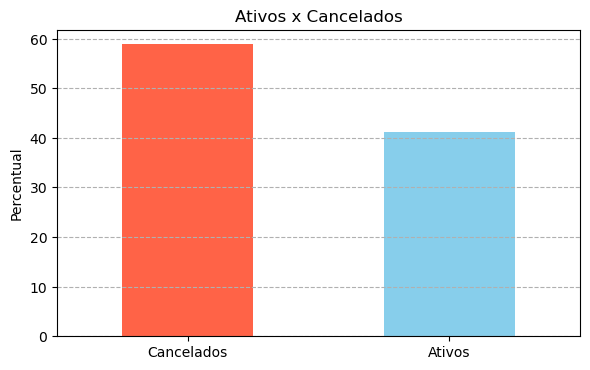

In [41]:
# ========= Churn Total =========

# Total de clientes que cancelaram
cancelados_total = df[df['CANCELADO'] == 'SIM'].shape[0]

# Total de clientes
total_clientes = df.shape[0]

# Taxa de churn total
churn_total = (cancelados_total / total_clientes) * 100

print(f"Churn total: {churn_total:.2f}%")



churn_total = df['CANCELADO'].value_counts(normalize=True).mul(100).round(2).rename('Percentual (%)')
print("Churn Total (%):")
display(churn_total)

# Renomeando os índices para o gráfico
churn_total_renomeado = churn_total.rename(index={'SIM': 'Cancelados', 'NAO': 'Ativos'})

# Plotando o gráfico
plt.figure(figsize=(6, 4))
churn_total_renomeado.plot(kind='bar', color=['tomato', 'skyblue'])
plt.title('Ativos x Cancelados')
plt.ylabel('Percentual')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.gca().set_xlabel('')
plt.show()



O percentual de cancelamento total (59%) é alto, indicando que mais da metade da base histórica de clientes já cancelou o plano.

# Churn por UF

Percentual de ativos e cancelados por UF:


CANCELADO,NAO,SIM
UF,,
ES,26.37,73.63
PI,30.31,69.69
MG,30.39,69.61
PR,30.53,69.47
SC,33.16,66.84
AM,34.59,65.41
RS,34.90,65.10
GO,36.10,63.90
SP,37.19,62.81


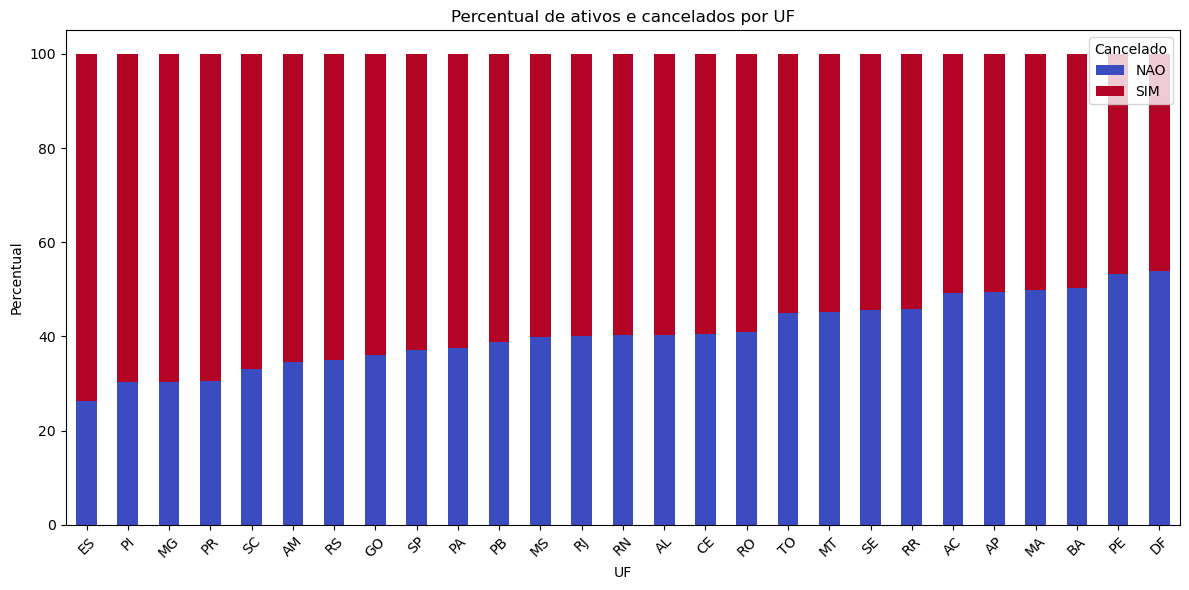

In [42]:
# ========= Churn por UF =========
churn_uf = df.groupby(['UF', 'CANCELADO']).size().unstack(fill_value=0)
churn_uf_percent = churn_uf.div(churn_uf.sum(axis=1), axis=0).mul(100).round(2)

# Ordenar pela taxa de churn (Cancelado = SIM) decrescente
if 'SIM' in churn_uf_percent.columns:
    churn_uf_percent = churn_uf_percent.sort_values(by='SIM', ascending=False)

print("Percentual de ativos e cancelados por UF:")
display(churn_uf_percent)

churn_uf_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Percentual de ativos e cancelados por UF')
plt.ylabel('Percentual')
plt.xticks(rotation=45)
plt.legend(title='Cancelado')
plt.tight_layout()
plt.show()

Com base no gráfico de percentual de ativos e cancelados (churn) por UF, podemos ter as seguintes observações/indícios:

Existe uma variação regional grande, pois o percentual de cancelamento varia muito entre as UFs

UFs com maior Churn:ES, PI, MG e PR. Acima de 69%

Já DF e PE possuem as menores taxas de cancelamento ficando abaixo de 47%.



# Churn por Região

Criando o mapeamento por região para ver o comportamento
Somente para análise dos dados, pois como é uma informação derivada de UF.
Caso queira utilizar terei que descartar UF para evitar instabilidade e garantir a convergencia do modelo.

Percentual de ativos e cancelados por região:


CANCELADO,NAO,SIM
regiao,,
Sul,33.12,66.88
Sudeste,36.19,63.81
Norte,39.10,60.90
Nordeste,47.38,52.62
Centro-Oeste,48.95,51.05


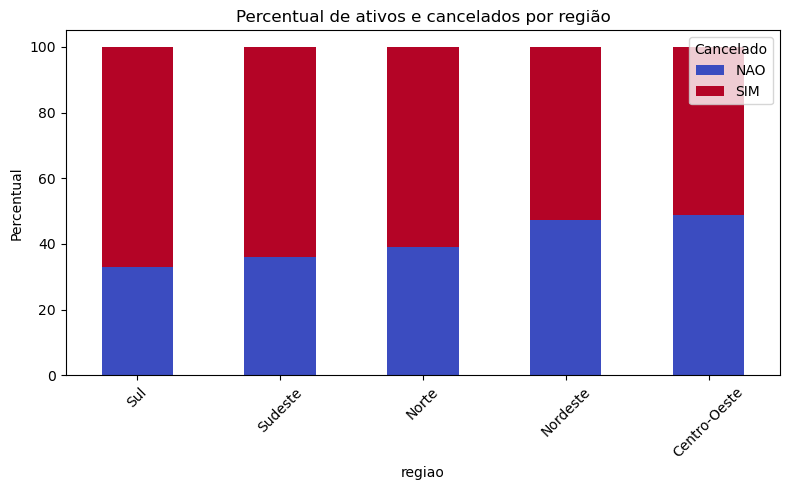

In [43]:
# Calcule o churn por regiao
churn_regiao = df.groupby(['regiao', 'CANCELADO']).size().unstack(fill_value=0)
churn_regiao_percent = churn_regiao.div(churn_regiao.sum(axis=1), axis=0).mul(100).round(2)

# Ordenar pela taxa de churn (Cancelado = SIM) decrescente
if 'SIM' in churn_regiao_percent.columns:
    churn_regiao_percent = churn_regiao_percent.sort_values(by='SIM', ascending=False)

print("Percentual de ativos e cancelados por região:")
display(churn_regiao_percent)

# Para visualizar com gráfico:
churn_regiao_percent.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='coolwarm')
plt.title('Percentual de ativos e cancelados por região')
plt.ylabel('Percentual')
plt.xticks(rotation=45)
plt.legend(title='Cancelado')
plt.tight_layout()
plt.show()


UFs do Sul Sudeste e Norte estão apresentando percentual de churn na maior que 60% enquanto Nordeste e Centro-Oeste em torno de 50%.

Estratégias regionais podem ser mais interessanes devido a esse desbalanceamento uma vez que o comportamento dos clientes também difere bastante de uma UF para outra. A análise por UF nos sugere que fatores geográficos e possivelmente socioeconômicos ou culturais podem estar influenciando nos cancelamentos.

# Churn por Sexo

Churn por Sexo (%):


CANCELADO,NAO,SIM
SEXO,,
F,42.25,57.75
M,39.81,60.19


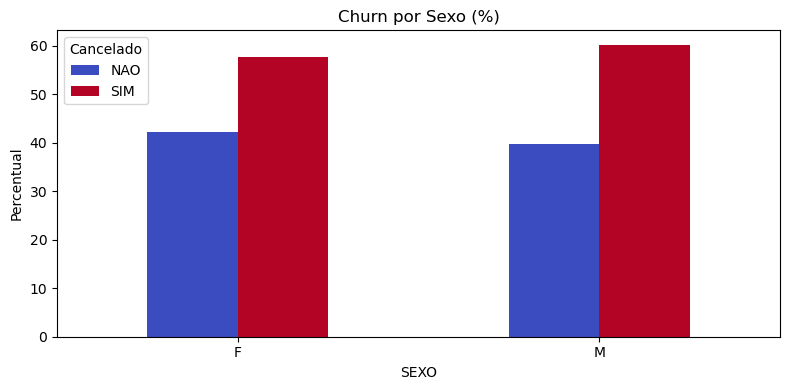

In [44]:
# ========= Churn por Sexo =========
df_sexo = df[df['SEXO'].notnull()]  # Filtra nulos
churn_sexo = df_sexo.groupby(['SEXO', 'CANCELADO']).size().unstack(fill_value=0)
churn_sexo_percent = churn_sexo.div(churn_sexo.sum(axis=1), axis=0).mul(100).round(2)

print("Churn por Sexo (%):")
display(churn_sexo_percent)

churn_sexo_percent.plot(kind='bar', stacked=False, figsize=(8, 4), colormap='coolwarm')
plt.title('Churn por Sexo (%)')
plt.ylabel('Percentual')
plt.xticks(rotation=0)
plt.legend(title='Cancelado')
plt.tight_layout()
plt.show()

Cancelamento é ligeiramente maior (2%) para o sexo masculino (60%) do que do sexo feminino (58%).

Propensão ao churn maior entre homens, mesmo sendo minoria na base. Homens têm uma tendência um pouco maior ao cancelamento do que as mulheres.

Não existe uma inversão entre os valores dos níveis (F e M), valores próximos o que pode ser um idicativo de que essa variável não será boa para o modelo logistico.




# Amplitude do Impacto Financeiro (situações extremas)
cancelamento x valor da mensalidade nos dá uma visão sobre a perda de receita.

**Considerando casos extremos todos cancelaram no último mês e o outro cenários todos cancelaram no primeiro mês:**

* Perda mínima: soma dos cancelamentos multiplicada pelo valor da mensalidade multiplicado por 1 mês.

* Perda máxima: soma dos cancelamentos multiplicada pelo valor da mensalidade multiplicado por 12 meses.

**Não existe a informação da data de cancelamento, mas podemos ter uma ideia da amplitude e também podemos calcular o valor médio para ter uma ideia deste montante.**

Perda mínima total (1 mês): R$ 34,875,730.00
Perda máxima total (12 meses): R$ 418,508,760.00
Perdas financeiras por UF (ordenadas):
    UF  VALOR_MENSALIDADE  perda_minima  perda_maxima
0   SP          6299400.0     6299400.0    75592800.0
1   RJ          5737020.0     5737020.0    68844240.0
2   BA          3801960.0     3801960.0    45623520.0
3   MG          3718270.0     3718270.0    44619240.0
4   DF          1781440.0     1781440.0    21377280.0
5   RS          1587800.0     1587800.0    19053600.0
6   MA          1491070.0     1491070.0    17892840.0
7   PE          1439750.0     1439750.0    17277000.0
8   PR          1166900.0     1166900.0    14002800.0
9   AL           836350.0      836350.0    10036200.0
10  SE           821900.0      821900.0     9862800.0
11  ES           797270.0      797270.0     9567240.0
12  RN           783940.0      783940.0     9407280.0
13  SC           643940.0      643940.0     7727280.0
14  CE           572230.0      572230.0     6866760.0
15 

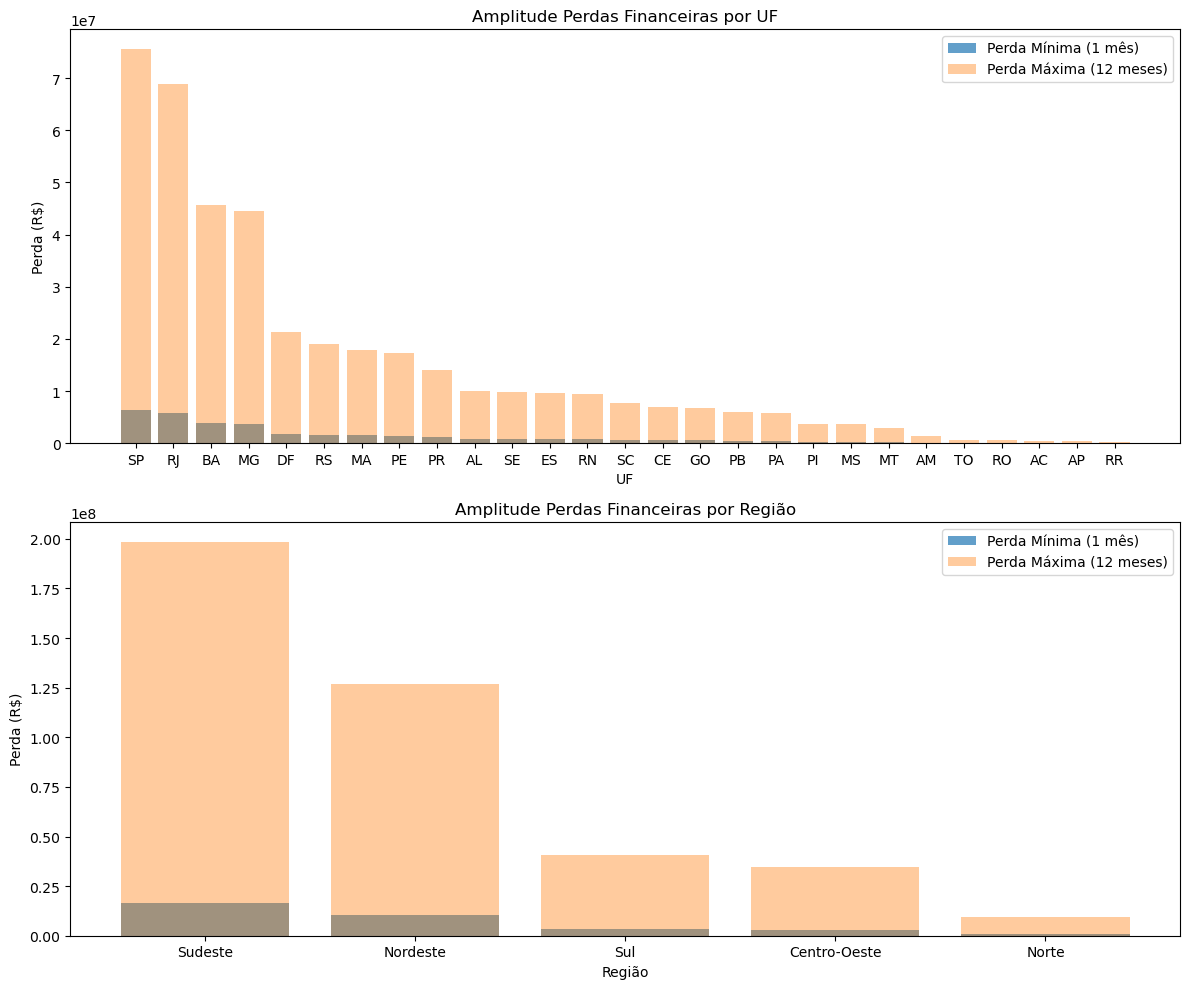

In [45]:
# Primeiro, criar um filtro para clientes que cancelaram
cancelados = df[df['CANCELADO'] == 'SIM']

# Calcular perda mínima total e perda máxima total
perda_minima_total = cancelados['VALOR_MENSALIDADE'].sum()
perda_maxima_total = cancelados['VALOR_MENSALIDADE'].sum() * 12

print(f'Perda mínima total (1 mês): R$ {perda_minima_total:,.2f}')
print(f'Perda máxima total (12 meses): R$ {perda_maxima_total:,.2f}')

# Perda mínima e máxima por UF, ordenando da maior para menor
perda_uf = cancelados.groupby('UF')['VALOR_MENSALIDADE'].sum().reset_index()
perda_uf['perda_minima'] = perda_uf['VALOR_MENSALIDADE']  # 1 mês
perda_uf['perda_maxima'] = perda_uf['VALOR_MENSALIDADE'] * 12  # 12 meses
perda_uf = perda_uf.sort_values(by='perda_minima', ascending=False).reset_index(drop=True)

print("Perdas financeiras por UF (ordenadas):")
print(perda_uf)

# Perda mínima e máxima por região, ordenando da maior para menor
perda_regiao = cancelados.groupby('regiao')['VALOR_MENSALIDADE'].sum().reset_index()
perda_regiao['perda_minima'] = perda_regiao['VALOR_MENSALIDADE']  # 1 mês
perda_regiao['perda_maxima'] = perda_regiao['VALOR_MENSALIDADE'] * 12  # 12 meses
perda_regiao = perda_regiao.sort_values(by='perda_minima', ascending=False).reset_index(drop=True)

print("Perdas financeiras por região (ordenadas):")
print(perda_regiao)

# Gráfico de barras para perdas por UF e por região, também em ordem
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico por UF
axs[0].bar(perda_uf['UF'], perda_uf['perda_minima'], label='Perda Mínima (1 mês)', alpha=0.7)
axs[0].bar(perda_uf['UF'], perda_uf['perda_maxima'], label='Perda Máxima (12 meses)', alpha=0.4)
axs[0].set_title('Amplitude Perdas Financeiras por UF')
axs[0].set_xlabel('UF')
axs[0].set_ylabel('Perda (R$)')
axs[0].legend()

# Gráfico por região
axs[1].bar(perda_regiao['regiao'], perda_regiao['perda_minima'], label='Perda Mínima (1 mês)', alpha=0.7)
axs[1].bar(perda_regiao['regiao'], perda_regiao['perda_maxima'], label='Perda Máxima (12 meses)', alpha=0.4)
axs[1].set_title('Amplitude Perdas Financeiras por Região')
axs[1].set_xlabel('Região')
axs[1].set_ylabel('Perda (R$)')
axs[1].legend()

plt.tight_layout()
plt.show()


Esse resultado está alinhado como a quantidade de clientes por região, mas cabe ainda uma análise bivariada do valor da mensalidade versus faixa de renda para entender essa distribuiçao.

          regiao  FAIXA_RENDA  Qtd_clientes  Soma_mensalidades  \
0       Nordeste  Média renda          6175          5464050.0   
1        Sudeste  Média renda          5967          5599580.0   
2   Centro-Oeste  Média renda          1876          1647920.0   
3            Sul  Média renda          1101           948540.0   
4          Norte  Média renda           363           309430.0   
5        Sudeste  Baixa renda         18449         17583780.0   
6       Nordeste  Baixa renda         13095         11893720.0   
7            Sul  Baixa renda          4013          3601720.0   
8   Centro-Oeste  Baixa renda          3683          3286750.0   
9          Norte  Baixa renda           980           841800.0   
10       Sudeste   Alta renda          2767          2572220.0   
11      Nordeste   Alta renda          2623          2305160.0   
12  Centro-Oeste   Alta renda           777           676590.0   
13           Sul   Alta renda           552           484110.0   
14        

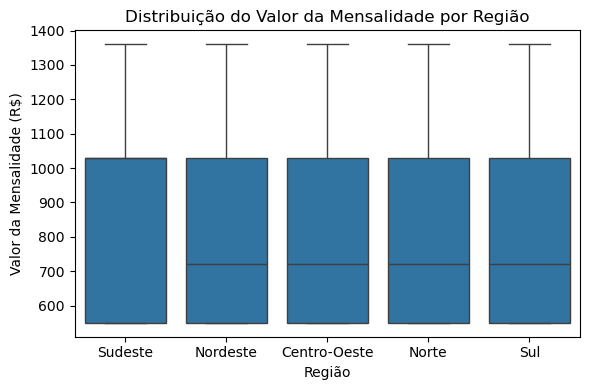

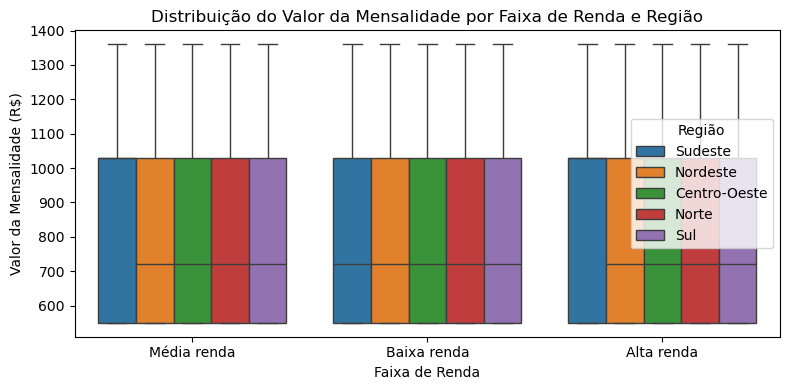

In [46]:
# Filtra apenas registros com valor de mensalidade não nulo
df_valid = df[df['VALOR_MENSALIDADE'].notnull()]

# Agrupa por região e faixa de renda e calcula agregados

distribuicao = (
    df_valid
    .groupby(['regiao', 'FAIXA_RENDA'])['VALOR_MENSALIDADE']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={
        'count': 'Qtd_clientes',
        'sum': 'Soma_mensalidades',
        'mean': 'Media_mensalidade'
    })
    .sort_values([ 'FAIXA_RENDA', 'Qtd_clientes'], ascending=False)
    .reset_index()
)

# Exibe o resultado de forma ordenada
print(distribuicao)

# Calcula estatísticos descritivos por região
boxplot_table = (
    df_valid
    .groupby('regiao')['VALOR_MENSALIDADE']
    .describe(percentiles=[.25, .5, .75])[['min', '25%', '50%', '75%', 'max']]
    .reset_index()
    .rename(columns={
        'min': 'Min',
        '25%': '1º Quartil',
        '50%': 'Mediana',
        '75%': '3º Quartil',
        'max': 'Máximo'
    })
)
print(boxplot_table)

plt.figure(figsize=(6,4))
sns.boxplot(
    x='regiao',
    y='VALOR_MENSALIDADE',
    data=df_valid,
    showfliers=False  # oculta outliers para facilitar visualização
)

# Calcula a média do valor da mensalidade para cancelados e não cancelados
medias = (
    df_valid
    .groupby('CANCELADO')['VALOR_MENSALIDADE']
    .mean()
    .reset_index()
    .rename(columns={'VALOR_MENSALIDADE': 'Media_mensalidade'})
)

# Exibe o resultado
print("Médias do valor da mensalidade para cancelados e não cancelados:")
print(medias)

# Calcula a média da mensalidade por região e status de cancelamento
medias_regiao_status = (
    df_valid
    .groupby(['regiao', 'CANCELADO'])['VALOR_MENSALIDADE']
    .mean()
    .reset_index()
)
print("Médias do valor da mensalidade para cancelados e não cancelados por região:")
print(medias_regiao_status)

plt.title('Distribuição do Valor da Mensalidade por Região')
plt.xlabel('Região')
plt.ylabel('Valor da Mensalidade (R$)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(
    x='FAIXA_RENDA',
    y='VALOR_MENSALIDADE',
    hue='regiao',
    data=df_valid,
    showfliers=False
)
plt.title('Distribuição do Valor da Mensalidade por Faixa de Renda e Região')
plt.xlabel('Faixa de Renda')
plt.ylabel('Valor da Mensalidade (R$)')
plt.legend(title='Região')
plt.tight_layout()
plt.show()


Distribuição de clientes por faixa de renda e região
A maior concentração de clientes está nas faixas de baixa e média renda, especialmente no Sudeste e Nordeste:
* Sudeste (Baixa renda): 18.449 clientes
* Nordeste (Baixa renda): 13.095 clientes

Alta renda representa uma pequena parcela da base, mesmo nas regiões mais ricas.

Indício que o serviço tem forte penetração nas classes populares (planos populares).

Os clientes de alta renda não são muitos e o valor médio da mensalidade é superior em todas as regiões (situação esperada).

Foco comercial no Sudeste e Nordeste é estratégico, mas há oportunidade de crescer com planos melhores/superiores nas classes mais altas.

Média de mensalidades entre faixas de renda estão relativamente próximas entre as faixas, o que pode indicar uma política de precificação pouco diferenciada por faixa de renda ou que clientes de baixa renda contratam planos mais caros que o esperado (talvez por necessidade ou falta de opções mais acessíveis)

Oportunidades para oferecer planos por perfil socioeconômico.

O valor da mensalidade, por si só, pode não ser uma variável ideal para uma regressão logística caso as médias entre os grupos (por exemplo, cancelados vs. não cancelados, inadimplentes vs. adimplentes) sejam muito próximas.

Em regressões logísticas, busca-se variáveis preditoras que apresentem boa capacidade de separação entre as classes (ou seja, médias ou distribuições significativamente diferentes).

Se a média do valor da mensalidade para os dois grupos está próxima, significa que esse atributo tem baixo poder discriminativo para o alvo da classificação



# Churn por Faixa de **Tempo de Plano**

Frequência Absoluta por Faixa de Tempo de Plano:


CANCELADO,NAO,SIM
TEMPO_FAIXA,,
0-11m,0,0
12-23m,0,0
24-35m,0,0
36-47m,0,0
48-59m,0,1
60-71m,0,0
72-83m,0,0
84-95m,0,0
96-107m,0,0


Churn por Faixa de Tempo de Plano (%):


CANCELADO,NAO,SIM
TEMPO_FAIXA,,
0-11m,NaN,NaN
12-23m,NaN,NaN
24-35m,NaN,NaN
36-47m,NaN,NaN
48-59m,0.00,100.00
60-71m,NaN,NaN
72-83m,NaN,NaN
84-95m,NaN,NaN
96-107m,NaN,NaN


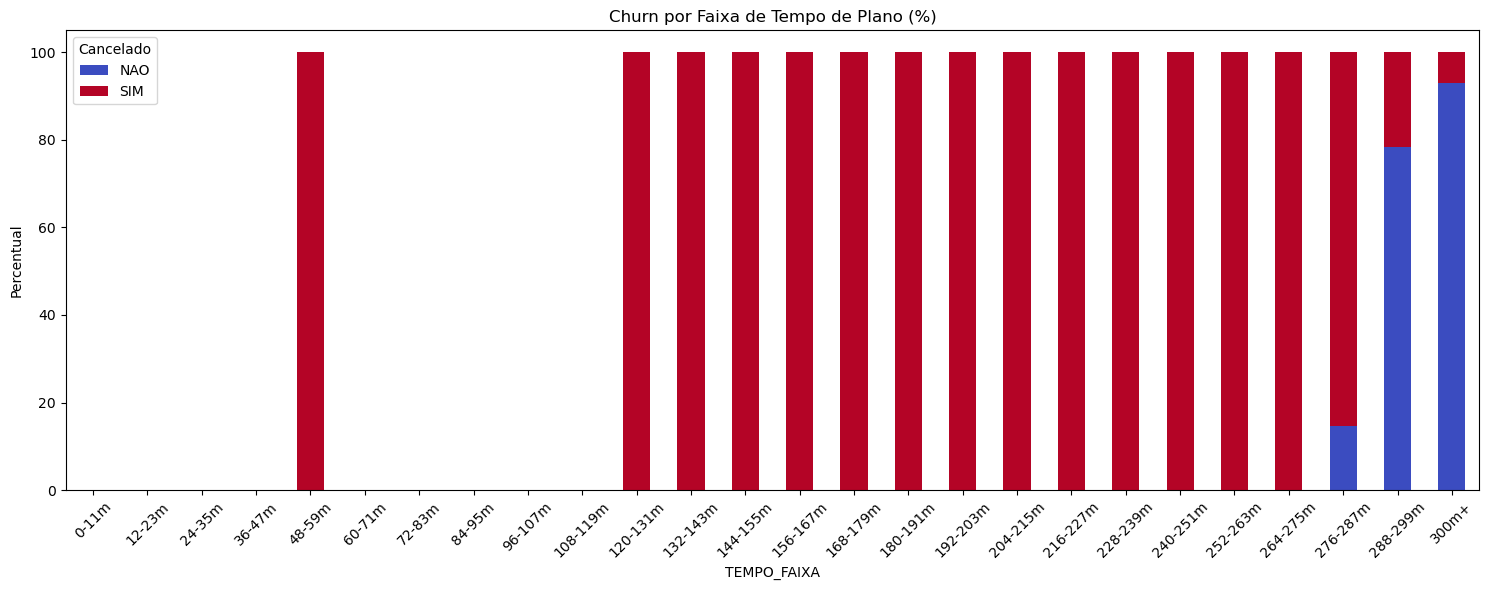

In [47]:
# Faixas de tempo de plano
bins = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288, 300, df['TEMPO_DE_PLANO_MESES'].max()+1]
labels = [
    '0-11m', '12-23m', '24-35m', '36-47m', '48-59m', '60-71m', '72-83m',
    '84-95m', '96-107m', '108-119m', '120-131m', '132-143m', '144-155m', '156-167m',
    '168-179m', '180-191m', '192-203m', '204-215m', '216-227m', '228-239m',
    '240-251m', '252-263m', '264-275m', '276-287m', '288-299m', '300m+'
]

# Coluna de faixa de tempo
df['TEMPO_FAIXA'] = pd.cut(df['TEMPO_DE_PLANO_MESES'], bins=bins, labels=labels, right=False, include_lowest=True)

# Calculo do churn por faixa
churn_tempo = df.groupby(['TEMPO_FAIXA', 'CANCELADO'], observed=False).size().unstack(fill_value=0)
churn_tempo_percent = churn_tempo.div(churn_tempo.sum(axis=1), axis=0).mul(100).round(2)

print("Frequência Absoluta por Faixa de Tempo de Plano:")
display(churn_tempo)

print("Churn por Faixa de Tempo de Plano (%):")
display(churn_tempo_percent)

# Plot do resultado
churn_tempo_percent.plot(kind='bar', stacked=True, figsize=(15, 6), colormap='coolwarm')
plt.title('Churn por Faixa de Tempo de Plano (%)')
plt.ylabel('Percentual')
plt.xticks(rotation=45)
plt.legend(title='Cancelado')
plt.tight_layout()
plt.show()


O churn por faixa de tempo nos mostra como a retenção/cancelamento varia conforme o tempo de relacionamento do cliente.

Estratégias diferenciadas por UF podem ser mais interessantes. Isso permitiria políticas de fidelização mais agressivas nos estados de maior cancelamento e manutenção de boas práticas nas regiões com menor cancelamento.

Investigar
* se os estados com churn alto têm características comuns (perfis de cliente, tipo de plano, atendimento, questões econômicas locais).

* quais faixas de tempo de plano têm maior peso nos estados de alto churn.


# Divisão dos dados em treino e teste

A separação dos dados em treino e teste deve ser feita antes de qualquer ajuste nas variáveis, como tratamento de valores ausentes (missings), outliers ou ajustes de dados inválidos.
Isso garante que não sejam transferidas as informações da base de teste para a base de treino.

Dividir na proporção 70-30 (treino-teste)
Ajustar apenas com base nas informações da base de treino:
* Preencher valores ausentes, tratar outliers, transformar variáveis, NORMALIZAR, etc.
* Ajustar apenas com parâmetros (ex: média, mediana) calculados somente no treino.
* Aplicar transformações ao teste usando esses mesmos parâmetros do treino.

Ajuste e tratamentos (imputação, normalização, encoding de categorias, etc.) serão realizados só nos dados de treino e aplicados a base de teste depois.

In [48]:
# Divisao treino e teste
df_original = df.copy() # cópia do dataframe caso precise dos dados originais depois

# removendo regiao, pois a distribuição de UF possui maoir variabilidade
# e com isso agrega mais para o modelo.
df = df.drop('regiao', axis=1)
# removendo titularidade (explicado anteriormente)
df = df.drop('TITULARIDADE', axis=1)

# Divide o dataframe completo em treino e teste, mantendo a estratificação pela variável resposta
df_treino, df_teste = train_test_split(
    df,
    test_size=0.3,
    random_state=2025,
    stratify=df['CANCELADO']
)


Proporção treino:
CANCELADO
SIM    0.588163
NAO    0.411837
Name: proportion, dtype: float64

Proporção teste:
CANCELADO
SIM    0.588146
NAO    0.411854
Name: proportion, dtype: float64


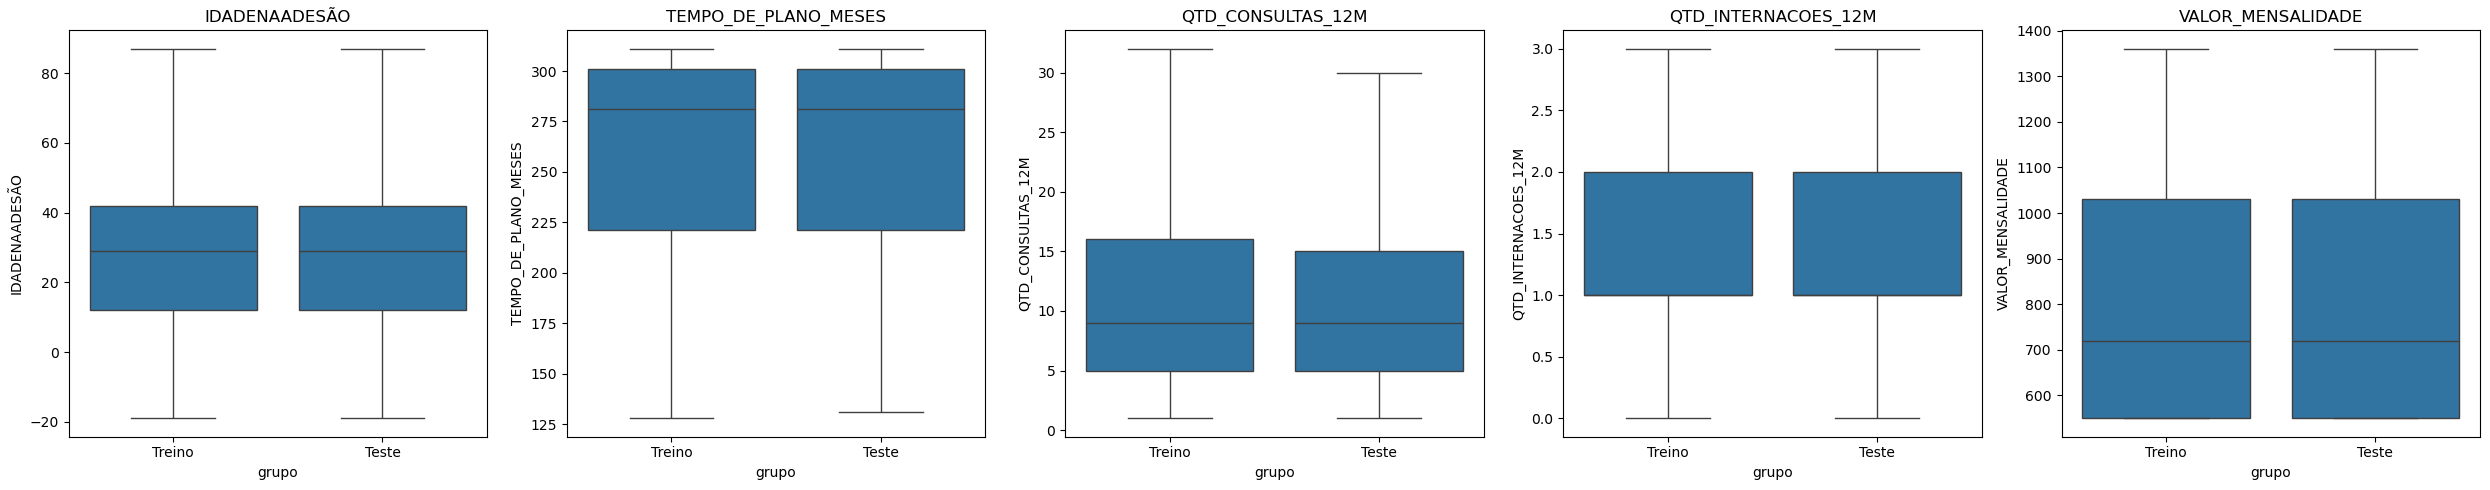


==== Proporções das variáveis categóricas ====

--- CANCELADO ---
Treino:
CANCELADO
SIM    0.588163
NAO    0.411837
Name: proportion, dtype: float64
Teste:
CANCELADO
SIM    0.588146
NAO    0.411854
Name: proportion, dtype: float64

--- FAIXA_RENDA ---
Treino:
FAIXA_RENDA
Baixa renda    0.642358
Média renda    0.245943
Alta renda     0.111699
Name: proportion, dtype: float64
Teste:
FAIXA_RENDA
Baixa renda    0.645074
Média renda    0.247732
Alta renda     0.107194
Name: proportion, dtype: float64

--- SEXO ---
Treino:
SEXO
F      0.559383
M      0.420940
NaN    0.019677
Name: proportion, dtype: float64
Teste:
SEXO
F      0.557637
M      0.422507
NaN    0.019856
Name: proportion, dtype: float64

--- UF ---
Treino:
UF
SP     0.159406
RJ     0.149087
BA     0.125580
MG     0.096093
DF     0.066211
MA     0.051326
PE     0.050025
RS     0.041445
PR     0.028540
SE     0.027479
RN     0.024652
AL     0.024412
NaN    0.020072
ES     0.019323
CE     0.018221
SC     0.017245
GO     0.016199
PB

In [49]:
# Verificando a divisão / verificando se existe alguma anomalia

# Proporções da variável resposta CANCELADO nos conjuntos de treino e teste
print('Proporção treino:')
print(df_treino['CANCELADO'].value_counts(normalize=True))
print('\nProporção teste:')
print(df_teste['CANCELADO'].value_counts(normalize=True))

# Variáveis numéricas para análise gráfica
numericas = df_treino.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preparando DataFrames para boxplots
df_treino_num = df_treino[numericas].copy()
df_treino_num['grupo'] = 'Treino'
df_teste_num = df_teste[numericas].copy()
df_teste_num['grupo'] = 'Teste'
dados_boxplot = pd.concat([df_treino_num, df_teste_num])

# boxplots lado a lado
fig, axes = plt.subplots(nrows=1, ncols=len(numericas), figsize=(5*len(numericas), 5))
if len(numericas) == 1:
    axes = [axes]
for i, col in enumerate(numericas):
    sns.boxplot(x='grupo', y=col, data=dados_boxplot, ax=axes[i], showfliers=False)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

# Variáveis categóricas
categoricas = df_treino.select_dtypes(include=['object', 'category']).columns.tolist()

# Verificando as proporções das variáveis categóricas em treino e teste
print('\n==== Proporções das variáveis categóricas ====')
for col in categoricas:
    print(f"\n--- {col} ---")
    print('Treino:')
    print(df_treino[col].value_counts(normalize=True, dropna=False))
    print('Teste:')
    print(df_teste[col].value_counts(normalize=True, dropna=False))



# Regras dos ajustes - base de dados de treino

## Imputação de Valores com KNN (avaliando)

Vou testar o método KNN (k-Nearest Neighbors) e para preservar a estrutura discreta da variável (valor_mensalidade) e não inventa valores fora do conjunto existente vou categorizála. O KNN atribui o valor mais frequente (no caso de categóricos). KNNImputer do scikit-learn só imputam valores em variáveis numéricas, com isso, precisarei codificar as variáveis.

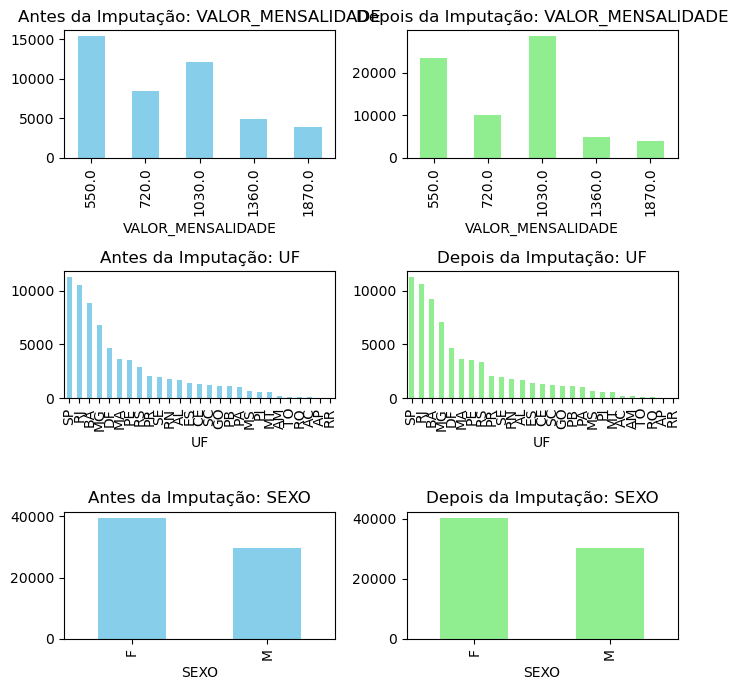

In [50]:
# Copia do DataFrame para evitar alteração sobre o original
df_impute = df_treino.copy()

# Converte VALOR_MENSALIDADE para categoria (discreto com poucos níveis)
df_impute['VALOR_MENSALIDADE'] = df_impute['VALOR_MENSALIDADE'].astype('category')

# Codificação dos dados categóricos
uf_code, uf_index = pd.factorize(df_impute['UF'])
sexo_code, sexo_index = pd.factorize(df_impute['SEXO'])
valor_mensalidade_code, valor_mensalidade_index = pd.factorize(df_impute['VALOR_MENSALIDADE'])

df_impute['UF'] = uf_code
df_impute['SEXO'] = sexo_code
df_impute['VALOR_MENSALIDADE'] = valor_mensalidade_code

# Substituindo -1 (ausentes após factorize) por np.nan
df_impute.loc[df_impute['UF'] == -1, 'UF'] = np.nan
df_impute.loc[df_impute['SEXO'] == -1, 'SEXO'] = np.nan
df_impute.loc[df_impute['VALOR_MENSALIDADE'] == -1, 'VALOR_MENSALIDADE'] = np.nan

# Imputação apenas nas colunas necessárias
cols_to_impute = ['VALOR_MENSALIDADE', 'UF', 'SEXO']
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputed_array = imputer.fit_transform(df_impute[cols_to_impute])
imputed_df = pd.DataFrame(imputed_array, columns=cols_to_impute)

# Decodificação dos valores imputados
for col, indexer in [('UF', uf_index), ('SEXO', sexo_index), ('VALOR_MENSALIDADE', valor_mensalidade_index)]:
    imputed_df[col] = imputed_df[col].round().astype(int)
    imputed_df[col] = imputed_df[col].map(dict(enumerate(indexer)))


# Visualização gráfica antes/depois

fig, axs = plt.subplots(3, 2, figsize=(7, 7))

# VALOR_MENSALIDADE: são valores discretos
df_treino['VALOR_MENSALIDADE'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Antes da Imputação: VALOR_MENSALIDADE')
imputed_df['VALOR_MENSALIDADE'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 1], color='lightgreen')
axs[0, 1].set_title('Depois da Imputação: VALOR_MENSALIDADE')

# UF
df_treino['UF'].value_counts().plot(kind='bar', ax=axs[1, 0], color='skyblue')
axs[1, 0].set_title('Antes da Imputação: UF')
imputed_df['UF'].value_counts().plot(kind='bar', ax=axs[1, 1], color='lightgreen')
axs[1, 1].set_title('Depois da Imputação: UF')

# SEXO
df_treino['SEXO'].value_counts().plot(kind='bar', ax=axs[2, 0], color='skyblue')
axs[2, 0].set_title('Antes da Imputação: SEXO')
imputed_df['SEXO'].value_counts().plot(kind='bar', ax=axs[2, 1], color='lightgreen')
axs[2, 1].set_title('Depois da Imputação: SEXO')

plt.tight_layout()
plt.show()


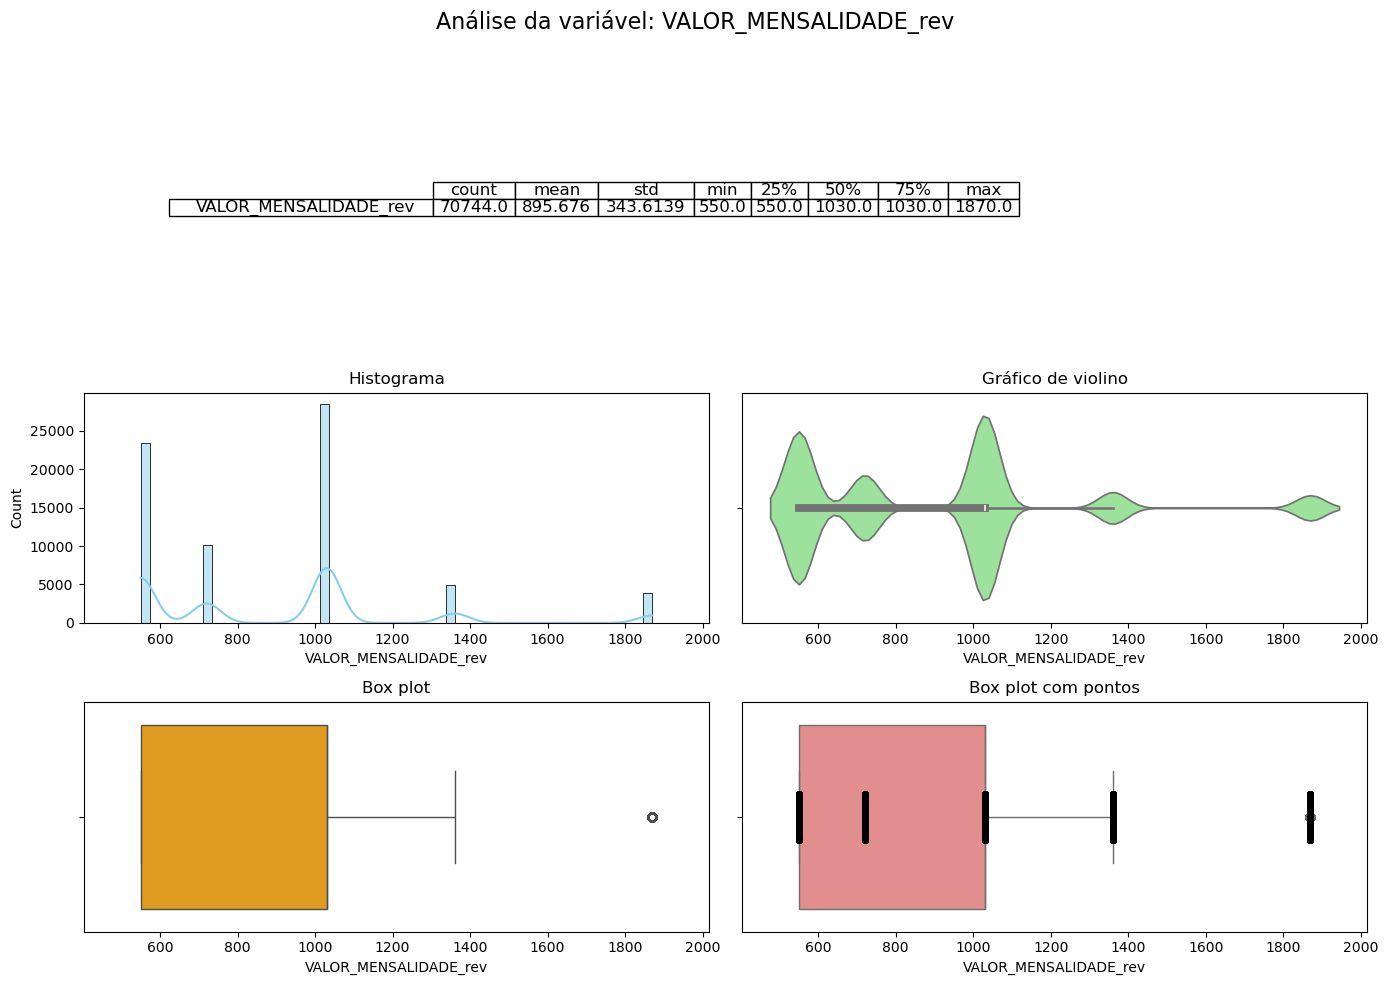

In [51]:
# Reverter a categoria e verificar como afetou media, mediana, etc
# Revertendo para tipo numérico
imputed_df['VALOR_MENSALIDADE_rev'] = imputed_df['VALOR_MENSALIDADE'].astype(float)

univariada_variavel_numerica(imputed_df,'VALOR_MENSALIDADE_rev')

Houve uma alteração visível na distribuiçao da VALOR_MENSALIDADE, o que me deixa desconfortável em adotar esse resultado para a VALOR_MENSALIDADE.

Acredito que o melhor caminho seja manter a variável categorizada e os valores ausentes serem classificados como uma categoria ('OUTROS')

## Aplicando as regras de ajuste

In [52]:
# Aplicando as regras de ajuste no Treino
# =======================================

# Aplicando as imputações de UF e SEXO feitas por KNN
# ===================================================
# Alinhar índices para atribuir os valores
imputed_df.index = df_treino.index  # ou df_impute.index, ambos funcionam

# Atualizar df_treino apenas onde havia valores ausentes
# apenas as colunas uf e sexo
for col in ['UF', 'SEXO']:
    df_treino[col] = df_treino[col].mask(df_treino[col].isna(), imputed_df[col])

# Categorizar variável VALOR_MENSALIDADE
df_treino['VALOR_MENSALIDADE'] = df_treino['VALOR_MENSALIDADE'].fillna('OUTROS').astype(str)

# TEMPO_FAIXA
# Faixas de 1 ano foram criadas anteriormente não é uma regra que causaria vazamento
# entre Treino e Teste. Foi criada enteriormente.
df_treino['TEMPO_FAIXA'] = df_treino['TEMPO_FAIXA'].astype(str)  # Garantir consistência

# titularidade já foi removida anteriormente não está no Treino nem no Teste
# df = df.drop(columns=['TITULARIDADE'],axis=1)

# Valores inválidos - Remoção
df_treino = df_treino[(df_treino['IDADENAADESÃO'] >= 0) & (df_treino['IDADENAADESÃO'] <= 150)]
df_treino = df_treino[df_treino['TEMPO_DE_PLANO_MESES'] >= 0]


# Resumo/Considerações finais sobre os ajustes

O maior ponto de atenção recai sobre a variável VALOR_MENSALIDADE, pois possui um percentual de dados ausentes muito elevado (36.81%).

O KNN afetou a distribuição para VALOR_MENSALIDADE, com isso, a opção por categorizar parece ser mais adequada.
Para UF e Sexo foi mantido a imputação gerada pelo KNN.

**IDADENAADESAO**: valores que estou considerando como erro de cadastro.
* valores maiores de 150 e negativos serão descartados.
* valores negativos serão descartados.
  

**TEMPO_DE_PLANO_MESES**: valores negativos serão descartados. Estou considerando como erro de cadastro.

**Entendo que uma conversa com o time de cadastro e de negócios seria extremamente importante para validação dessas considerações.**
Tanto o descarte de observações (informações) da amostra quanto a imputação de valores é algo que precisa ser cuidadosamente avaliado e a área de negócios precisa estar ciente de todos os ajustes e considerações realizados na base para a construção do modelo.

Categorizei a variável VALOR_MESALIDADE criando a categoria OUTROS para os valores ausentes. Deste modo mantenho as informações para a análise.
Os valores das mensalidades apesar de numéricos são valores discreto, permitindo que eu use essa estatégia sem descaracterizar os dados. Creio que seja o mais adequado para este estudo.

# Avaliar a linearidade das variáveis numéricas com o logito de p

* IDADENAADESÃO
* TEMPO_DE_PLANO_MESES
* QTD_CONSULTAS_12M
* QTD_INTERNACOES_12M

O modelo logistico pressupõe que o logito de p e não p diretamente, seja linear em relação às variáveis explicativas (X).
Isso significa que para cada unidade de aumento em X, o efeito sobre o logito de p deve ser constante.
Não é necessário que p varie linearmente com X, pois a relação entre X e
p é sigmoidal. O enfoque é na linearidade do logito.

Ajuste adequado do modelo: Se a linearidade não for respeitada, a função de ligação logito não será o melhor ajuste para os dados, levando a estimativas de parâmetros incorretas, interpretações equivocadas e, potencialmente, diminuição da capacidade preditiva do modelo.

Interpretação dos coeficientes: A interpretação padrão dos coeficientes (odds ratios) só é válida se essa linearidade existir. Se não houver linearidade, os odds ratios estarão errados e as conclusões sobre o efeito das variáveis podem ser inválidas.

Inferência estatística: A significância dos coeficientes e a validade dos testes estatísticos dependem dessa suposição.



/tmp/ipykernel_1269567/3181754155.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('percentil').agg(


<Figure size 1200x600 with 0 Axes>

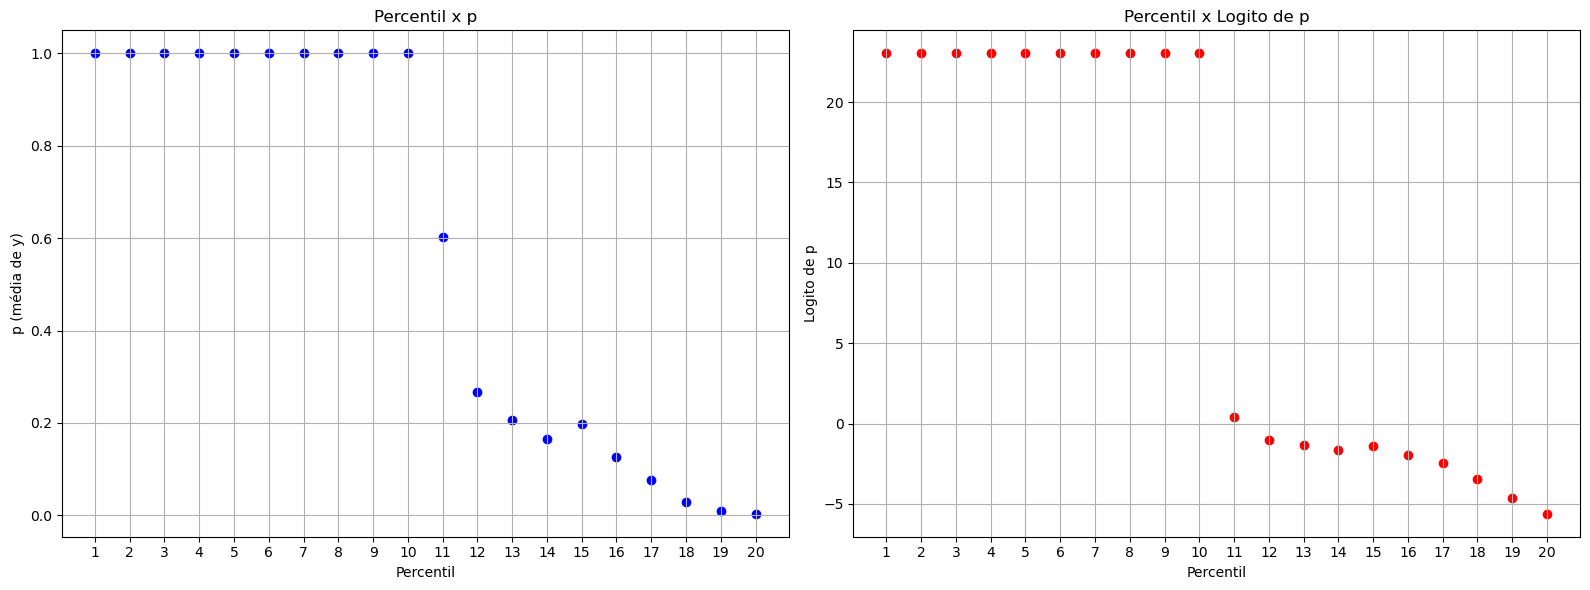

,percentil,n,min_x,max_x,p,logito_p
0,1,3522,52,159,1.000000,23.025851
1,2,3535,160,176,1.000000,23.025851
2,3,3537,177,193,1.000000,23.025851
3,4,3416,194,208,1.000000,23.025851
4,5,3388,209,221,1.000000,23.025851
5,6,3640,222,235,1.000000,23.025851
6,7,3316,236,247,1.000000,23.025851
7,8,3523,248,259,1.000000,23.025851
8,9,3555,260,270,1.000000,23.025851
9,10,3335,271,281,1.000000,23.025851


In [53]:
# verificando os níveis da variável
df_treino['CANCELADO'].unique()

# Criando a cancelado_num - alterando para 0 e 1 para chamar a função
# e verificar a linearidade das variáveis numericas com a CANCELADO
df_treino['CANCELADO_NUM'] = df_treino['CANCELADO'].map({'SIM': 1, 'NAO': 0})

analise_var_numerica_por_percentil_2(df_treino,'TEMPO_DE_PLANO_MESES','CANCELADO_NUM',q=20,grafico='ambos')



/tmp/ipykernel_1269567/3181754155.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('percentil').agg(


<Figure size 1200x600 with 0 Axes>

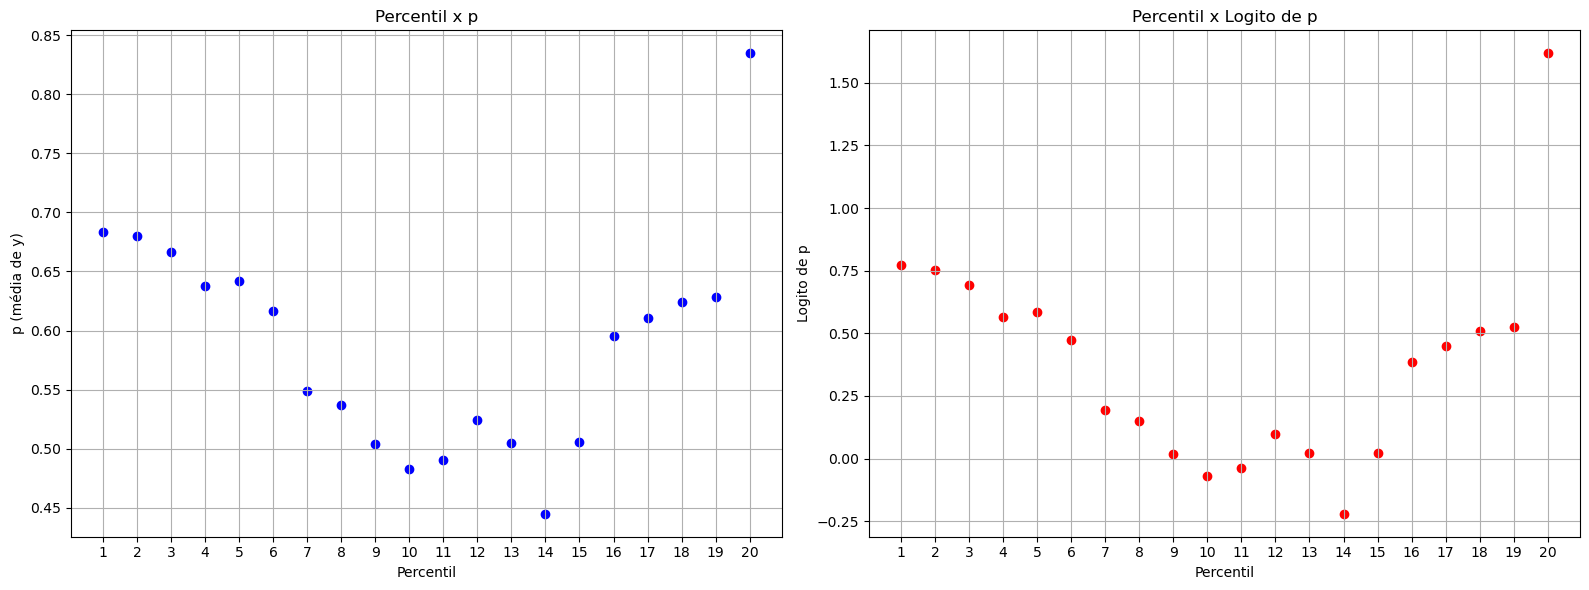

,percentil,n,min_x,max_x,p,logito_p
0,1,4440,0,1,0.683784,0.771216
1,2,2750,2,3,0.679636,0.752101
2,3,3776,4,6,0.666843,0.693942
3,4,3404,7,9,0.638073,0.567010
4,5,3069,10,12,0.642229,0.585051
5,6,3521,13,16,0.616302,0.473882
6,7,3544,17,21,0.548533,0.194744
7,8,4526,22,24,0.537119,0.148749
8,9,2809,25,26,0.504450,0.017800
9,10,3787,27,29,0.482968,-0.068154


In [54]:
analise_var_numerica_por_percentil_2(df_treino,'IDADENAADESÃO','CANCELADO_NUM',q=20,grafico='ambos')


/tmp/ipykernel_1269567/3181754155.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('percentil').agg(


<Figure size 1200x600 with 0 Axes>

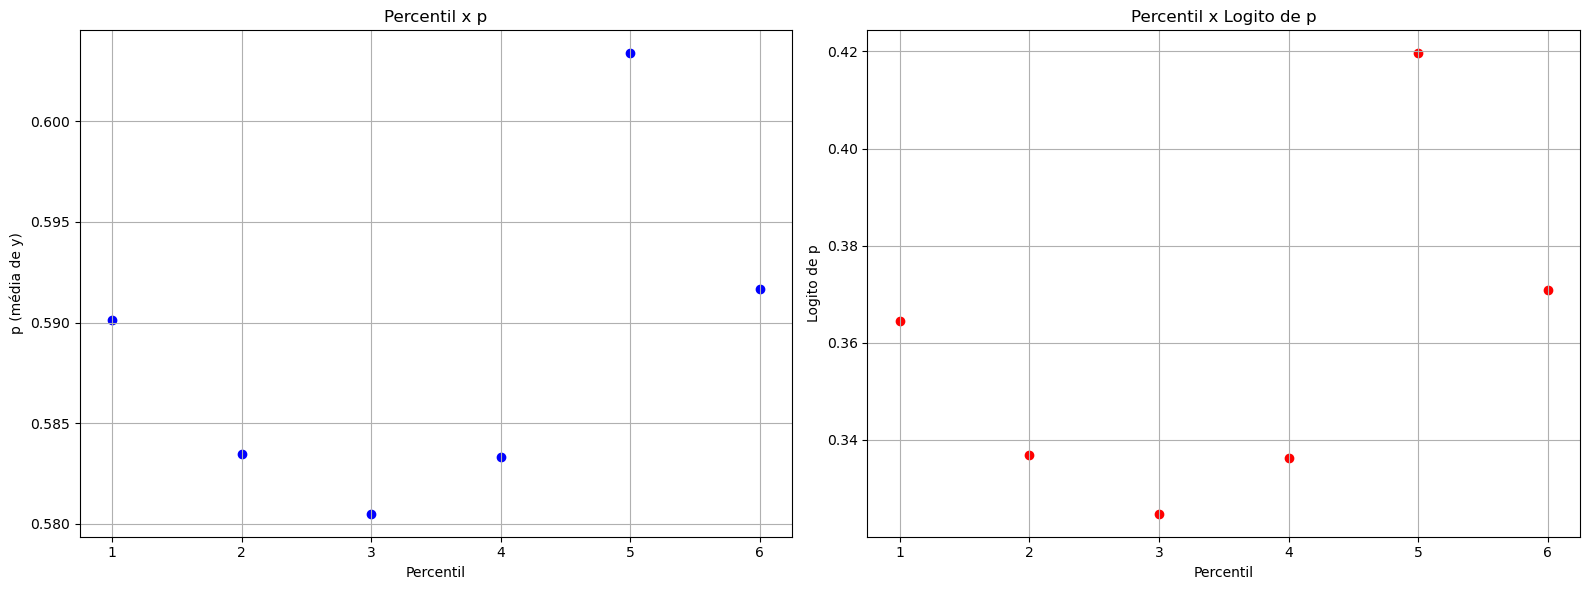

,percentil,n,min_x,max_x,p,logito_p
0,1,49474,0,1,0.590108,0.364412
1,2,10054,2,2,0.583449,0.336950
2,3,5342,3,3,0.580494,0.324802
3,4,2539,4,4,0.583301,0.336337
4,5,827,5,5,0.603386,0.419592
5,6,1129,6,9,0.591674,0.370890


In [55]:
analise_var_numerica_por_percentil_2(df_treino,'QTD_INTERNACOES_12M','CANCELADO_NUM',q=40,grafico='ambos')


/tmp/ipykernel_1269567/3181754155.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('percentil').agg(


<Figure size 1200x600 with 0 Axes>

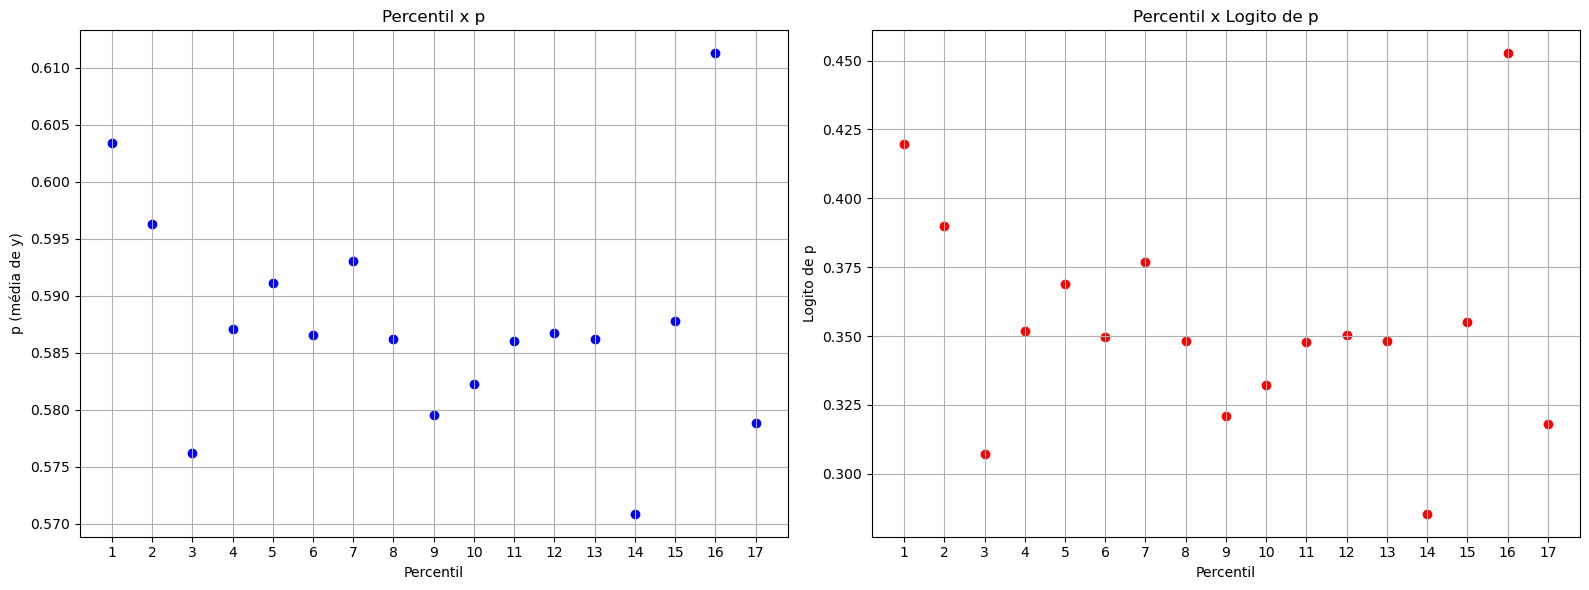

,percentil,n,min_x,max_x,p,logito_p
0,1,8076,1,2,0.603393,0.419622
1,2,4055,3,3,0.596301,0.390075
2,3,3988,4,4,0.576229,0.307311
3,4,3904,5,5,0.587090,0.351949
4,5,3982,6,6,0.591160,0.368764
5,6,4039,7,7,0.586531,0.349644
6,7,4055,8,8,0.593095,0.376775
7,8,3939,9,9,0.586189,0.348235
8,9,4124,10,10,0.579534,0.320862
9,10,4048,11,11,0.582263,0.332070


In [56]:
analise_var_numerica_por_percentil_2(df_treino,'QTD_CONSULTAS_12M','CANCELADO_NUM',q=20,grafico='ambos')

Não me parece existir uma linearidade das variáveis numéricas com o logito de p, com isso, categorizar as variáveis para usar no modelo de regressão logística.



# Categorização das variáveis numericas

(devido a não linearidade com logito de p)

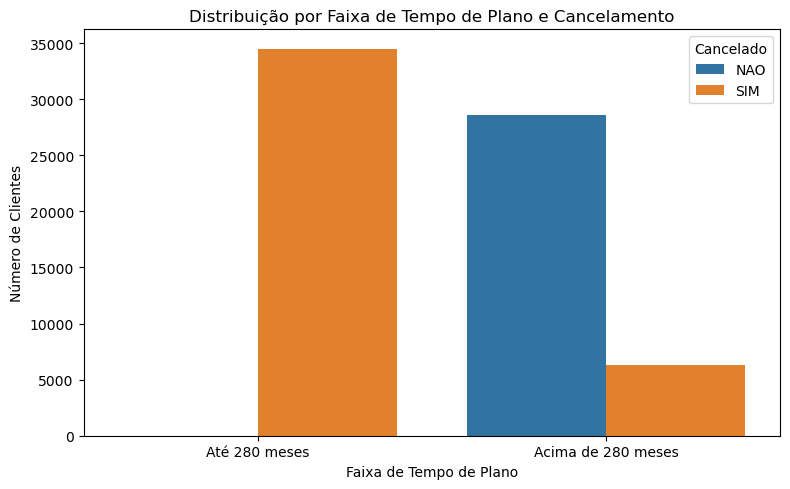

In [57]:
# Categorizar  TEMPO_DE_PLANO_MESES em dois níveis acima e abaixo de 280
# Reagrupar na TEMPO_FAIXA

tempo_faixa_bins = [-1, 280, np.inf]
df_treino['TEMPO_FAIXA'] = pd.cut(
    df_treino['TEMPO_DE_PLANO_MESES'],
    bins=tempo_faixa_bins,
    labels=['Até 280 meses', 'Acima de 280 meses']
)
df_treino['TEMPO_FAIXA'].value_counts()

# Tamanho da figura
plt.figure(figsize=(8, 5))

# Gráfico de colunas
sns.countplot(data=df_treino, x='TEMPO_FAIXA', hue='CANCELADO')

# Título e rótulos
plt.title('Distribuição por Faixa de Tempo de Plano e Cancelamento')
plt.xlabel('Faixa de Tempo de Plano')
plt.ylabel('Número de Clientes')
plt.legend(title='Cancelado')

# Exibir
plt.tight_layout()
plt.show()

Não tenho indícios que esta variável será significativa para o modelo.

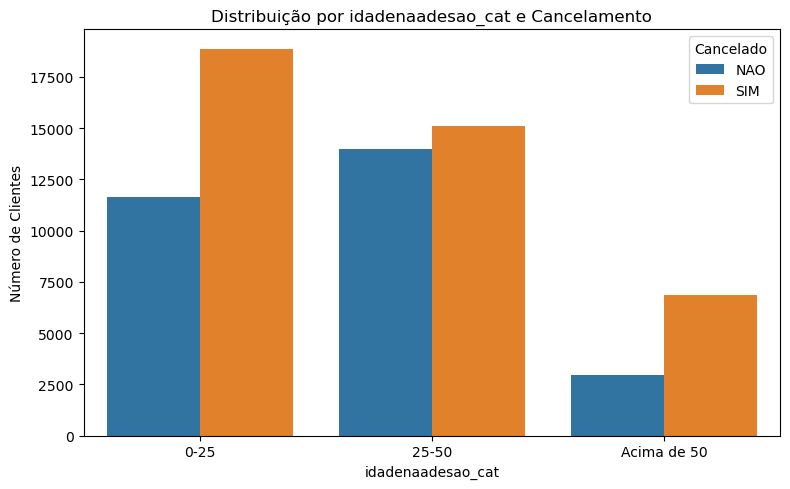

In [58]:
# Categorizar  IDADENAADESÃO em níveis 0-25, 25-50 e acima e de 50

idadenaadesao_bins = [-1, 25, 50, np.inf]
df_treino['idadenaadesao_cat'] = pd.cut(
    df_treino['IDADENAADESÃO'],
    bins=idadenaadesao_bins,
    labels=['0-25', '25-50', 'Acima de 50']
)
df_treino['idadenaadesao_cat'].value_counts()

# Tamanho da figura
plt.figure(figsize=(8, 5))

# Gráfico de colunas
sns.countplot(data=df_treino, x='idadenaadesao_cat', hue='CANCELADO')

# Título e rótulos
plt.title('Distribuição por idadenaadesao_cat e Cancelamento')
plt.xlabel('idadenaadesao_cat')
plt.ylabel('Número de Clientes')
plt.legend(title='Cancelado')

# Exibir
plt.tight_layout()
plt.show()

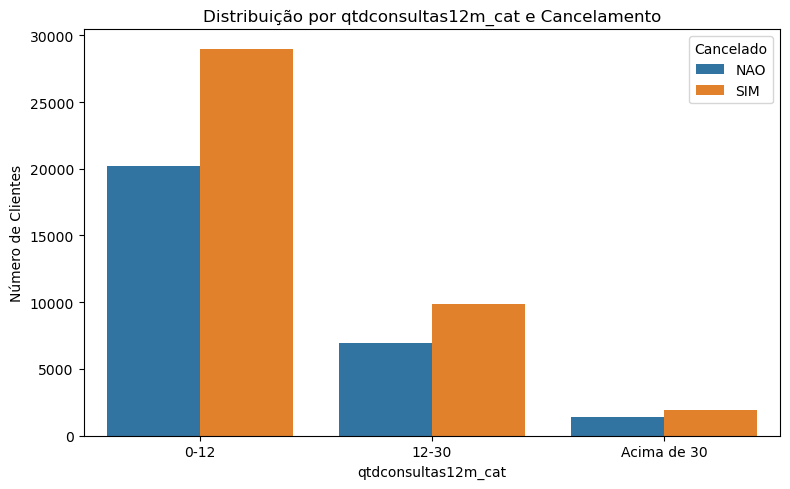

In [59]:
# Categorizar QTD_CONSULTAS_12M em níveis 0-12, 12-30 e acima de 30

qtdconsultas12m_bins = [-1, 12, 30, np.inf]
df_treino['qtdconsultas12m_cat'] = pd.cut(
    df_treino['QTD_CONSULTAS_12M'],
    bins=qtdconsultas12m_bins,
    labels=['0-12', '12-30', 'Acima de 30']
)
df_treino['qtdconsultas12m_cat'].value_counts()

# Tamanho da figura
plt.figure(figsize=(8, 5))

# Gráfico de colunas
sns.countplot(data=df_treino, x='qtdconsultas12m_cat', hue='CANCELADO')

# Título e rótulos
plt.title('Distribuição por qtdconsultas12m_cat e Cancelamento')
plt.xlabel('qtdconsultas12m_cat')
plt.ylabel('Número de Clientes')
plt.legend(title='Cancelado')

# Exibir
plt.tight_layout()
plt.show()

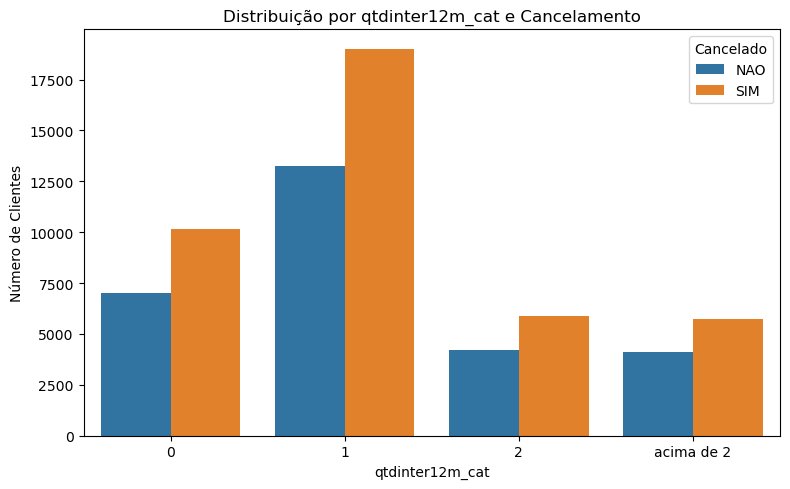

In [60]:
# Categorizar QTD_INTERNACOES_12M em níveis 0, 1, 2 e  acima de 2

qtdinter12m_bins = [-1, 0, 1, 2, np.inf]
df_treino['qtdinter12m_cat'] = pd.cut(
    df_treino['QTD_INTERNACOES_12M'],
    bins=qtdinter12m_bins,
    labels=['0', '1', '2', 'acima de 2']
)

df_treino['qtdinter12m_cat'].value_counts()

# Tamanho da figura
plt.figure(figsize=(8, 5))

# Gráfico de colunas
sns.countplot(data=df_treino, x='qtdinter12m_cat', hue='CANCELADO')

# Título e rótulos
plt.title('Distribuição por qtdinter12m_cat e Cancelamento')
plt.xlabel('qtdinter12m_cat')
plt.ylabel('Número de Clientes')
plt.legend(title='Cancelado')

# Exibir
plt.tight_layout()
plt.show()

In [61]:
# Remoção variáveis numericas que foram categorizadas
# Remoção da CANCELADO e manter a CANCELADO_NUM
# por ser a variável resposta e já esta com 0 e 1
df_treino = df_treino.drop(columns=['TEMPO_DE_PLANO_MESES','IDADENAADESÃO','QTD_CONSULTAS_12M','QTD_INTERNACOES_12M','CANCELADO'],axis=1)

# Criando o Modelo

In [62]:
# Seleciono somente as variáveis que serão utilizadas
modelo_churn = df_treino[['CANCELADO_NUM', 'FAIXA_RENDA', 'SEXO', 'UF', 'INADIMPLENTE', 'VALOR_MENSALIDADE', 'TEMPO_FAIXA', 'idadenaadesao_cat', 'qtdconsultas12m_cat', 'qtdinter12m_cat']]

modelo_churn = modelo_churn.copy()  # cópia explícita para evitar warning

# Separar a coluna CANCELADO_NUM - variável resposta
y = modelo_churn['CANCELADO_NUM']

# Seleciona as colunas do tipo object
obj_cols = modelo_churn.select_dtypes(include='object').columns

# Converte todas as colunas object para category
modelo_churn[obj_cols] = modelo_churn[obj_cols].astype('category')

# Cria as dummies para o modelo
# Gerar dummies para as colunas, exceto CANCELADO_NUM (removendo  grau de liberdade para evitar multicolinearidade)
modelo_churn_dummies = pd.get_dummies(modelo_churn.drop(columns=['CANCELADO_NUM']), drop_first=True, dtype=np.int64)

X = modelo_churn_dummies
X = sm.add_constant(X)  # Adiciona uma constante para o modelo (beta zero)

modelo_churn = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(modelo_churn.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:          CANCELADO_NUM   No. Observations:                69365
Model:                            GLM   Df Residuals:                    69321
Model Family:                Binomial   Df Model:                           43
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8187.2
Date:                Mon, 22 Sep 2025   Deviance:                       16374.
Time:                        21:55:50   Pearson chi2:                 1.81e+04
No. Iterations:                    30   Pseudo R-squ. (CS):             0.6733
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

# Analisando as probabilidades dos testes individuais de cada uma das variáveis

FAIXA_RENDA_Média renda __________ 0.999

UF_RO ____________________________ 0.799

TEMPO_FAIXA_Acima de 280 meses __ 0.999

qtdconsultas12m_cat_12-30 _______ 0.938

qtdinter12m_cat_1 ______________  0.885

Quando probabilidades estão próximas de 1: isso indica a variável não é significativa para o modelo, ou seja, ela tem o mesmo comportamento que a variável que está na casela de referência (dummie que foi removida)

# Odds Ratio

In [63]:
# coeficientes do modelo
coeficientes = modelo_churn.params

odds_ratios = np.exp(coeficientes)


resultado = pd.DataFrame({
    'coeficiente': coeficientes,
    'odds_ratio': odds_ratios
})

resultado['odds_ratio'] = resultado['odds_ratio'].apply(lambda x: f"{x:,.4f}")

print(resultado)

                                 coeficiente              odds_ratio
const                              27.792573  1,175,333,009,599.9434
FAIXA_RENDA_Baixa renda             3.052347                 21.1650
FAIXA_RENDA_Média renda           -28.546910                  0.0000
SEXO_M                              0.030169                  1.0306
UF_AL                               0.984438                  2.6763
UF_AM                               1.687385                  5.4053
UF_AP                              -1.196893                  0.3021
UF_BA                               0.465737                  1.5932
UF_CE                               1.137941                  3.1203
UF_DF                               0.548789                  1.7312
UF_ES                               1.478704                  4.3873
UF_GO                               0.696994                  2.0077
UF_MA                               0.235600                  1.2657
UF_MG                             

# Interpretação da Odds Ratio

Vou interpretar a primeira que é a FAIXA_RENDA_Baixa renda em relação a Categoria de referência: "FAIXA_RENDA_Alta renda" (não aparece explicitamente no modelo - é o grupo base).

FAIXA_RENDA_Baixa renda: OR = 21.1650.

Isso significa:

Se compararmos um cliente de baixa renda com um de alta renda, **o cliente de baixa renda tem uma probabilidade de cancelar aproximadamente 21.1650 vezes maior do que um cliente de alta renda**, dado que todas as outras características são iguais.
Ou então (em termos percentuais - mais adequado para a área de negócios),  Odd Ratio entre "FAIXA_RENDA_Baixa renda" e "FAIXA_RENDA_Alta renda" é 21.1650, a interpretação em percentual seria: (21.1650 − 1) * 100 = 20.1650 * 100 = 2016.50 %.

Ou seja, **a chance de cancelamento para a faixa de baixa renda é 2007,52% maior do que para a faixa de alta renda (sua categoria de referência)**.

Para as demais odds ratio, podese aplicar o mesmo racional.

Obs.: Quando a odds ratio for inferior a 1, isso indica que a variável está associada a uma redução na chance do evento ocorrer, em comparação com a categoria de referência (ou o valor base).

Também podemos ter uma comparação entre os estados, por exemplo: RJ e SP
UF	Coeficiente	OR (odds ratio)
RJ	1.053489	2.8676
SP	0.920080	2.5095

Razão dos odds = OR(rj)/OR(sp) = 2.8676/2.5095 aproximadamente 1.143

Ou seja, os odds de cancelamento no RJ são 14.3% maiores que os de SP.

**Clientes no RJ têm chances de cancelamento aproximadamente 14,3% maiores que os de SP (controlando para todas as outras variáveis do modelo).**

**Entre MG e SP: clientes em MG têm chances de cancelamento aproximadamente 44% maiores que os de SP (controlando para todas as outras variáveis do modelo)**

# Reagrupando as variáveis categoricas

Dado resultado do modelo, podemos reagrupa alguns níves de algumas variáves, conforme comentado na análise das probabilidades.

In [64]:
# Reagrupar as variáveis categoricas não significativas para o modelo

# FAIXA_RENDA_Média renda           0.999
# UF_RO                             0.799
# TEMPO_FAIXA_Acima de 280 meses    0.999
# qtdconsultas12m_cat_12-30         0.886
# qtdinter12m_cat_acima de 2        0.886
# idadenaadesao_cat_acima de 50     0,791

# Reagrupando AC, RO : ACRO
df_treino['UF'] = df_treino['UF'].replace({'AC': 'ACRO', 'RO': 'ACRO'})
df_treino['UF'] = df_treino['UF'].astype('category')

# Reagrupando FAIXA_RENDA_Média e FAIXA_RENDA_Alta => 'Média/Alta'
df_treino['FAIXA_RENDA'] = df_treino['FAIXA_RENDA'].replace({'Média renda': 'Média/Alta', 'Alta renda': 'Média/Alta'})
df_treino['FAIXA_RENDA'] = df_treino['FAIXA_RENDA'].astype('category')

# Reagrupando 'qtdconsultas12m_cat_0-12' e 'qtdconsultas12m_cat_12-30' => '0-30'
df_treino['qtdconsultas12m_cat'] = df_treino['qtdconsultas12m_cat'].astype(str).replace({'0-12': '0-30', '12-30': '0-30'})
df_treino['qtdconsultas12m_cat'] = df_treino['qtdconsultas12m_cat'].astype('category')

# Reagrupando 'qtdinter12m_cat_0' e 'qtdinter12m_cat_1' => '0/1'
df_treino['qtdinter12m_cat'] = df_treino['qtdinter12m_cat'].astype(str).replace({'0': '0/1', '1': '0/1'})
df_treino['qtdinter12m_cat'] = df_treino['qtdinter12m_cat'].astype('category')

# Reagrupando 'idadenaadesao_cat_0-25' e 'idadenaadesao_cat_acima de 50' => '0/1'
df_treino['idadenaadesao_cat'] = df_treino['idadenaadesao_cat'].astype(str).replace({'0-25': '0-25 e 50+', 'acima de 50': '0-25 e 50+'})
df_treino['idadenaadesao_cat'] = df_treino['idadenaadesao_cat'].astype('category')

# reset no índice
df_treino = df_treino.reset_index(drop=True)

# Removendo TEMPO_FAIXA_Acima de 280 meses (2 níveis)

df_treino.drop(columns=['TEMPO_FAIXA'], axis=1, inplace=True)



# Refazendo o modelo após ajuste

In [65]:
# refazendo o modelo
# del modelo_churn

modelo_churn = df_treino[['CANCELADO_NUM', 'FAIXA_RENDA', 'SEXO', 'UF', 'INADIMPLENTE', 'VALOR_MENSALIDADE', 'idadenaadesao_cat', 'qtdconsultas12m_cat', 'qtdinter12m_cat']]

modelo_churn = modelo_churn.copy()  # cópia explícita para evitar warning

# Separar a coluna CANCELADO_NUM - variável resposta
y = modelo_churn['CANCELADO_NUM']

# Seleciona as colunas do tipo object
obj_cols = modelo_churn.select_dtypes(include='object').columns

# Converte todas as colunas object para category
modelo_churn[obj_cols] = modelo_churn[obj_cols].astype('category')

# Cria as dummies para o modelo
# Gerar dummies para as colunas, exceto CANCELADO_NUM (removendo  grau de liberdade para evitar multicolinearidade)
modelo_churn_dummies = pd.get_dummies(modelo_churn.drop(columns=['CANCELADO_NUM']), drop_first=True, dtype=np.int64)

X = modelo_churn_dummies
X = sm.add_constant(X)  # Adiciona uma constante para o modelo (beta zero)

modelo_churn = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(modelo_churn.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          CANCELADO_NUM   No. Observations:                69365
Model:                            GLM   Df Residuals:                    69326
Model Family:                Binomial   Df Model:                           38
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21222.
Date:                Mon, 22 Sep 2025   Deviance:                       42444.
Time:                        21:55:53   Pearson chi2:                 7.09e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5243
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Aindo podemos agrupar alguns estados ...

**Obs.: Optei por não usar uma função para realizar  a seleção de variáveis, pois permite uma visão mais ampla e uma análise mais detalhada**

# Métricas de qualidade (TREINO)

* MSE e RMSE

* Precision / Recall no corte 0,5

* Lift

* KS

* Curva ROC e AUC

In [66]:
# Nova base (cópia dos dados de entrada do modelo)
churn_metricas = X.copy()  # matriz de variáveis independentes com dummies + constante

# previsões (valores ajustados/preditos pelo modelo)
y_chapeu = modelo_churn.predict(X)

# coluna de previsões à nova base
churn_metricas['y_chapeu'] = y_chapeu

# Se desejar, inclua o y real para facilitar análises
churn_metricas['CANCELADO_NUM'] = y.values


In [67]:
# criando as regras de decisão

# Para cada threshold de 0.1 a 0.9 (passo 0.1)
for t in np.arange(0.1, 1.0, 0.1):
    col_name = f'decisao_{str(round(t, 1)).replace(".", "_")}'
    churn_metricas[col_name] = np.where(churn_metricas['y_chapeu'] >= t, 1.0, 0.0)


In [68]:
#Calculando o MSE
churn_metricas['MSE'] = (churn_metricas['CANCELADO_NUM'] - churn_metricas['y_chapeu'])**2
MSE_modelo = churn_metricas['MSE'].mean()
print("MSE do modelo:", MSE_modelo)

MSE do modelo: 0.08997864776783951


Variável alvo (y) varia entre 0 e 1 => um MSE de 0.090 é relativamente alto,pois o erro quadrático médio está em 9% da faixa total.

In [69]:
#Calculando o RMSE
RMSE_modelo = np.sqrt(MSE_modelo)
print("RMSE do modelo:", RMSE_modelo)

RMSE do modelo: 0.29996441083541814


In [70]:
y_true = churn_metricas['CANCELADO_NUM'].values
y_prob = churn_metricas['y_chapeu'].values
thresholds = np.arange(0.1, 1.0, 0.1)
results = []

# Função para calcular o KS
def kolmogorov_smirnov(y_true, y_prob):
    fpr, tpr, thresh = roc_curve(y_true, y_prob)
    return np.max(np.abs(tpr - fpr))

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # KS calcula-se sobre as probabilidades, não sobre threshold fixo – mas pode mostrar para cada corte
    ks = kolmogorov_smirnov(y_true, y_prob)

    # Lift no threshold
    # Proporção de positivos no grupo predito como 1 em relação à proporção total de positivos
    if sum(y_pred) > 0:
        lift = (y_true[y_pred == 1].mean()) / y_true.mean()
    else:
        lift = np.nan  # Evita divisão por zero

    results.append({
        'threshold': round(t,1),
        'precision': prec,
        'recall': rec,
        'accuracy': acc,
        'f1_score': f1,
        'ks': ks,
        'lift': lift,
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)


   threshold  precision    recall  accuracy  f1_score        ks      lift
0        0.1   0.816327  0.974712  0.856095  0.888517  0.747732  1.387516
1        0.2   0.843010  0.967778  0.875009  0.901095  0.747732  1.432868
2        0.3   0.854793  0.961407  0.881208  0.904971  0.747732  1.452897
3        0.4   0.862956  0.956187  0.884884  0.907182  0.747732  1.466771
4        0.5   0.868054  0.951924  0.886585  0.908056  0.747732  1.475436
5        0.6   0.871595  0.945577  0.886023  0.907080  0.747732  1.481455
6        0.7   0.889633  0.901274  0.876133  0.895416  0.747732  1.512115
7        0.8   0.923401  0.740848  0.811375  0.822112  0.747732  1.569510
8        0.9   0.963936  0.465670  0.675384  0.627972  0.747732  1.638408


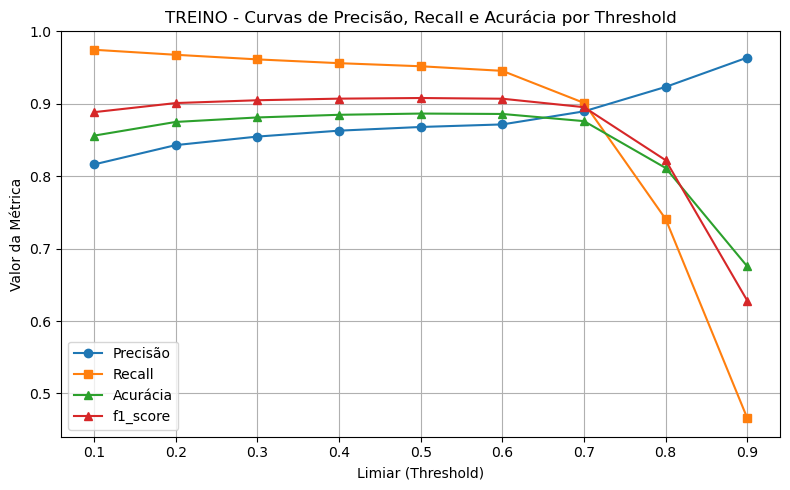

In [71]:
plt.figure(figsize=(8,5))
plt.plot(metrics_df['threshold'], metrics_df['precision'], marker='o', label='Precisão')
plt.plot(metrics_df['threshold'], metrics_df['recall'], marker='s', label='Recall')
plt.plot(metrics_df['threshold'], metrics_df['accuracy'], marker='^', label='Acurácia')
plt.plot(metrics_df['threshold'], metrics_df['f1_score'], marker='^', label='f1_score')

plt.xlabel('Limiar (Threshold)')
plt.ylabel('Valor da Métrica')
plt.title('TREINO - Curvas de Precisão, Recall e Acurácia por Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Precsão**: de todos que estou dizendo que sao 1, quantos acertei

**Recall**: de todos que sao 1, quantos estou pegando

Precisão e Recall estão acima de 0.80 indicando que o modelo tem metricas equilibradas.
Acurácia: Se mantém acima de 0.85 e só cai para valores baixos em thresholds muito altos.

Precisão e Recall: Ambos superiores a 0.80 para faixas intermediárias de threshold, revelando bom equilíbrio entre identificar positivos e minimizar falsos positivos.

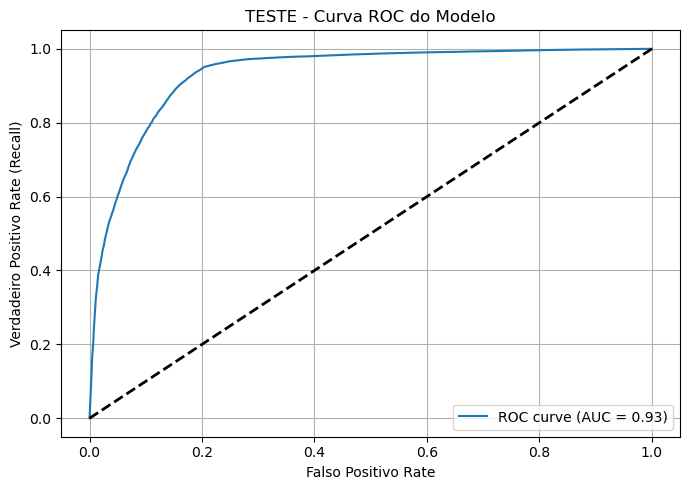

In [72]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Verdadeiro Positivo Rate (Recall)')
plt.title('TESTE - Curva ROC do Modelo')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


# Verificando o comportamento do modelo com dados de TESTE

## Aplicando as regras do TREINO exatamente igual para a base de TESTE

In [73]:
# Cópia da base de teste
df_teste_impute = df_teste.copy()

# Converte VALOR_MENSALIDADE para categoria
df_teste_impute['VALOR_MENSALIDADE'] = df_teste_impute['VALOR_MENSALIDADE'].astype('category')

# Aplicando os mesmos mapeamentos do treino
df_teste_impute['UF'] = df_teste_impute['UF'].map(dict(zip(uf_index, range(len(uf_index)))))
df_teste_impute['SEXO'] = df_teste_impute['SEXO'].map(dict(zip(sexo_index, range(len(sexo_index)))))
df_teste_impute['VALOR_MENSALIDADE'] = df_teste_impute['VALOR_MENSALIDADE'].map(dict(zip(valor_mensalidade_index, range(len(valor_mensalidade_index)))))

# Substituindo valores não mapeados (ou seja, NaN após o map) por np.nan
df_teste_impute['UF'] = df_teste_impute['UF'].where(df_teste_impute['UF'].notna(), np.nan)
df_teste_impute['SEXO'] = df_teste_impute['SEXO'].where(df_teste_impute['SEXO'].notna(), np.nan)
df_teste_impute['VALOR_MENSALIDADE'] = df_teste_impute['VALOR_MENSALIDADE'].where(df_teste_impute['VALOR_MENSALIDADE'].notna(), np.nan)

# Aplicando a imputação usando o imputador treinado no df_treino
imputed_array_teste = imputer.transform(df_teste_impute[cols_to_impute])
imputed_df_teste = pd.DataFrame(imputed_array_teste, columns=cols_to_impute)

# Decodificação dos valores imputados (mesmo que no treino)
for col, indexer in [('UF', uf_index), ('SEXO', sexo_index), ('VALOR_MENSALIDADE', valor_mensalidade_index)]:
    imputed_df_teste[col] = imputed_df_teste[col].round().astype(int)
    imputed_df_teste[col] = imputed_df_teste[col].map(dict(enumerate(indexer)))

# Criando a cancelado_num - alterando para 0 e 1 para chamar a função
# e verificar a linearidade das variáveis numericas com a CANCELADO
df_teste['CANCELADO_NUM'] = df_teste['CANCELADO'].map({'SIM': 1, 'NAO': 0})
df_teste['CANCELADO_NUM'] = (df_teste['CANCELADO'] == 'SIM').astype(int)


In [74]:
# Aplicar imputações de SEXO e UF
# ===============================

# Garante que o DataFrame imputado tenha o mesmo índice de df_teste
imputed_df_teste = pd.DataFrame(imputed_array_teste, columns=cols_to_impute, index=df_teste.index)

# Substituir os valores ausentes nas colunas originais pelas imputações
for col in ['UF', 'SEXO']:
    df_teste[col] = df_teste[col].mask(df_teste[col].isna(), imputed_df_teste[col])

# Ajustes e categorizações
# ========================

# VALOR_MENSALIDADE
df_teste['VALOR_MENSALIDADE'] = df_teste['VALOR_MENSALIDADE'].fillna('OUTROS').astype(str)

# Garantir consistência na variável já existente
df_teste['TEMPO_FAIXA'] = df_teste['TEMPO_FAIXA'].astype(str)

# Remover valores inválidos APÓS a imputação
df_teste = df_teste[(df_teste['IDADENAADESÃO'] >= 0) & (df_teste['IDADENAADESÃO'] <= 150)]
df_teste = df_teste[df_teste['TEMPO_DE_PLANO_MESES'] >= 0]

# Categorizar variáveis numéricas
df_teste['TEMPO_FAIXA'] = pd.cut(
    df_teste['TEMPO_DE_PLANO_MESES'],
    bins=tempo_faixa_bins,
    labels=['Até 280 meses', 'Acima de 280 meses']
)

df_teste['idadenaadesao_cat'] = pd.cut(
    df_teste['IDADENAADESÃO'],
    bins=idadenaadesao_bins,
    labels=['0-25', '25-50', 'Acima de 50']
)

df_teste['qtdconsultas12m_cat'] = pd.cut(
    df_teste['QTD_CONSULTAS_12M'],
    bins=qtdconsultas12m_bins,
    labels=['0-12', '12-30', 'Acima de 30']
)

df_teste['qtdinter12m_cat'] = pd.cut(
    df_teste['QTD_INTERNACOES_12M'],
    bins=qtdinter12m_bins,
    labels=['0', '1', '2', 'acima de 2']
)

# Drop de colunas que não serão usadas
df_teste = df_teste.drop(columns=['TEMPO_DE_PLANO_MESES', 'IDADENAADESÃO', 'QTD_CONSULTAS_12M',
                                  'QTD_INTERNACOES_12M', 'CANCELADO'], axis=1)


In [75]:
# Etapas no Teste — Preparo igual ao do Treino
modelo_churn_teste = df_teste[['CANCELADO_NUM', 'FAIXA_RENDA', 'SEXO', 'UF', 'INADIMPLENTE', 'VALOR_MENSALIDADE',
                               'idadenaadesao_cat', 'qtdconsultas12m_cat', 'qtdinter12m_cat']]

modelo_churn_teste = modelo_churn_teste.copy()

# Separar variável dependente
y_teste = modelo_churn_teste['CANCELADO_NUM']

# Converte colunas object para category
obj_cols = modelo_churn_teste.select_dtypes(include='object').columns
modelo_churn_teste[obj_cols] = modelo_churn_teste[obj_cols].astype('category')

# Criação de dummies no teste
modelo_churn_dummies_teste = pd.get_dummies(modelo_churn_teste.drop(columns=['CANCELADO_NUM']),
                                            drop_first=True, dtype=np.int64)

# Alinhar colunas com as do modelo treinado
X_teste = modelo_churn_dummies_teste.reindex(columns=X.columns.drop('const'), fill_value=0)

# Adicionar a constante como no treino
X_teste = sm.add_constant(X_teste)


# Previsão usando os dados de TESTE

In [76]:
# Probabilidades previstas pelo modelo para os dados de teste
y_chapeu_teste = modelo_churn.predict(X_teste)


# Avaliação das Métricas TESTE

In [77]:
# Cópia dos dados de entrada do modelo (variáveis independentes)
churn_metricas_teste = X_teste.copy()

# Adiciona as previsões ao dataframe
churn_metricas_teste['y_chapeu'] = y_chapeu_teste

# Adiciona o y real da base de teste para facilitar análises
churn_metricas_teste['CANCELADO_NUM'] = y_teste.reset_index(drop=True).values



In [78]:
# criando as regras de decisão

# Criando colunas de decisão com diferentes thresholds de classificação
for t in np.arange(0.1, 1.0, 0.1):
    # Nome da nova coluna com o threshold aplicado
    col_name = f'decisao_{str(round(t, 1)).replace(".", "_")}'

    # Se a probabilidade prevista for maior ou igual ao threshold, classifica como 1 (cancelado)
    churn_metricas_teste[col_name] = np.where(churn_metricas_teste['y_chapeu'] >= t, 1.0, 0.0)


In [79]:
# Calculando o MSE entre o valor real (0 ou 1) e a probabilidade prevista (entre 0 e 1)
churn_metricas_teste['MSE'] = (churn_metricas_teste['CANCELADO_NUM'] - churn_metricas_teste['y_chapeu'])**2

# Média dos erros quadráticos (MSE)
MSE_modelo_teste = churn_metricas_teste['MSE'].mean()
print("MSE do modelo (teste):", MSE_modelo_teste)

# Raiz do MSE (RMSE) – interpretação no mesmo intervalo que y_chapeu
RMSE_modelo_teste = np.sqrt(MSE_modelo_teste)
print("RMSE do modelo (teste):", RMSE_modelo_teste)


MSE do modelo (teste): 0.2744233047540139
RMSE do modelo (teste): 0.5238542781671387


In [80]:
y_true_teste = churn_metricas_teste['CANCELADO_NUM'].values
y_prob_teste = churn_metricas_teste['y_chapeu'].values
thresholds = np.arange(0.1, 1.0, 0.1)
results_teste = []

# Função para calcular o KS
def kolmogorov_smirnov(y_true, y_prob):
    fpr, tpr, thresh = roc_curve(y_true, y_prob)
    return np.max(np.abs(tpr - fpr))

for t in thresholds:
    y_pred_teste = (y_prob_teste >= t).astype(int)
    prec = precision_score(y_true_teste, y_pred_teste, zero_division=0)
    rec = recall_score(y_true_teste, y_pred_teste, zero_division=0)
    acc = accuracy_score(y_true_teste, y_pred_teste)
    f1 = f1_score(y_true_teste, y_pred_teste, zero_division=0)

    # KS calcula-se sobre as probabilidades, não sobre threshold fixo – mas pode mostrar para cada corte
    ks = kolmogorov_smirnov(y_true_teste, y_prob_teste)

    # Lift no threshold
    # Proporção de positivos no grupo predito como 1 em relação à proporção total de positivos
    if sum(y_pred_teste) > 0:
        lift = (y_true_teste[y_pred_teste == 1].mean()) / y_true_teste.mean()
    else:
        lift = np.nan  # Evita divisão por zero

    results_teste.append({
        'threshold': round(t,1),
        'precision': prec,
        'recall': rec,
        'accuracy': acc,
        'f1_score': f1,
        'ks': ks,
        'lift': lift,
    })

metrics_teste_df = pd.DataFrame(results_teste)
print(metrics_teste_df)

   threshold  precision    recall  accuracy  f1_score        ks      lift
0        0.1   0.588372  1.000000  0.588372  0.740849  0.385856  1.000000
1        0.2   0.588372  1.000000  0.588372  0.740849  0.385856  1.000000
2        0.3   0.588372  1.000000  0.588372  0.740849  0.385856  1.000000
3        0.4   0.588372  1.000000  0.588372  0.740849  0.385856  1.000000
4        0.5   0.588392  1.000000  0.588406  0.740865  0.385856  1.000034
5        0.6   0.592203  0.994625  0.593856  0.742386  0.385856  1.006511
6        0.7   0.629864  0.949677  0.642038  0.757394  0.385856  1.070521
7        0.8   0.717827  0.784983  0.691935  0.749904  0.385856  1.220022
8        0.9   0.848910  0.491908  0.649541  0.622882  0.385856  1.442811


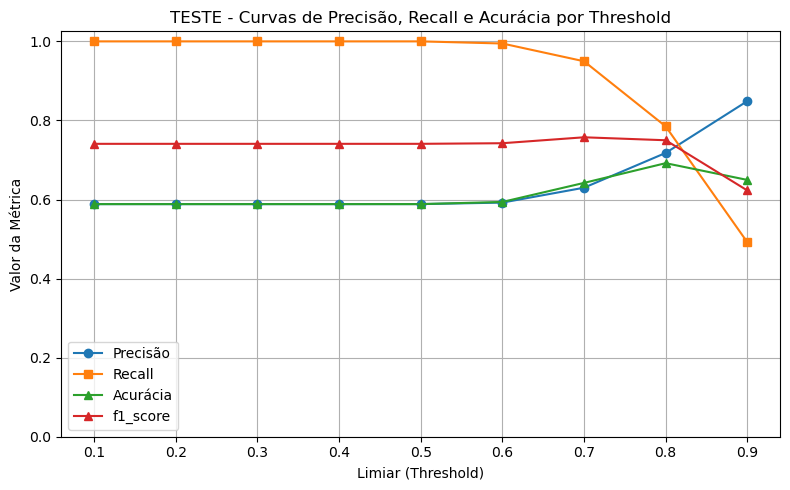

In [81]:
plt.figure(figsize=(8,5))
plt.plot(metrics_teste_df['threshold'], metrics_teste_df['precision'], marker='o', label='Precisão')
plt.plot(metrics_teste_df['threshold'], metrics_teste_df['recall'], marker='s', label='Recall')
plt.plot(metrics_teste_df['threshold'], metrics_teste_df['accuracy'], marker='^', label='Acurácia')
plt.plot(metrics_teste_df['threshold'], metrics_teste_df['f1_score'], marker='^', label='f1_score')

plt.xlabel('Limiar (Threshold)')
plt.ylabel('Valor da Métrica')
plt.title('TESTE - Curvas de Precisão, Recall e Acurácia por Threshold')
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

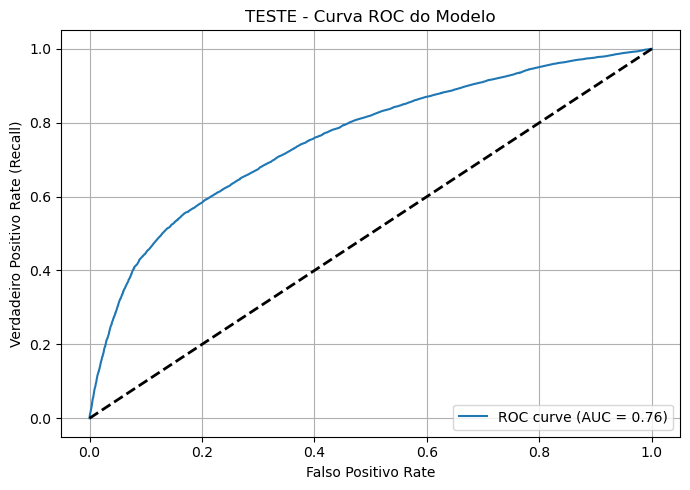

In [82]:
fpr, tpr, _ = roc_curve(y_true_teste, y_prob_teste)
auc = roc_auc_score(y_true_teste, y_prob_teste)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Verdadeiro Positivo Rate (Recall)')
plt.title('TESTE - Curva ROC do Modelo')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


# Separação TESTE x TREINO

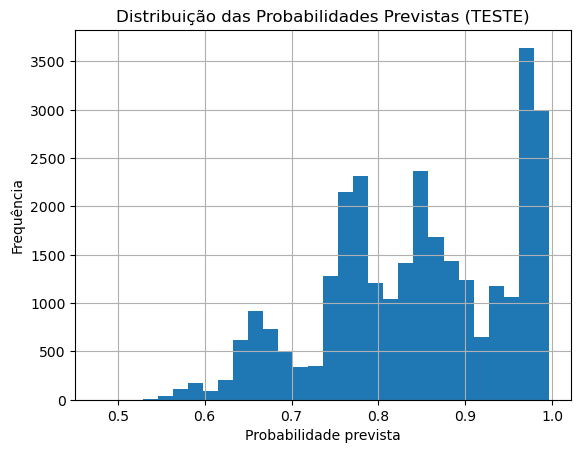

In [83]:
plt.hist(y_chapeu_teste, bins=30)
plt.title("Distribuição das Probabilidades Previstas (TESTE)")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()


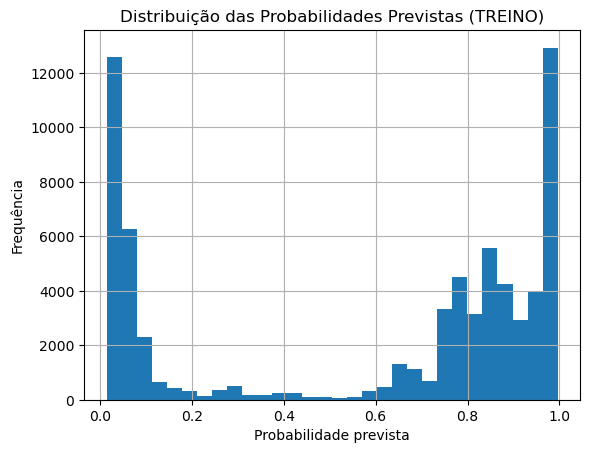

In [84]:
plt.hist(y_chapeu, bins=30)
plt.title("Distribuição das Probabilidades Previstas (TREINO)")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101063 entries, 0 to 101062
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   CANCELADO             101063 non-null  object  
 1   FAIXA_RENDA           101063 non-null  object  
 2   IDADENAADESÃO         101063 non-null  int64   
 3   TEMPO_DE_PLANO_MESES  101063 non-null  int64   
 4   SEXO                  99069 non-null   object  
 5   UF                    99027 non-null   object  
 6   INADIMPLENTE          101063 non-null  object  
 7   QTD_CONSULTAS_12M     101063 non-null  int64   
 8   QTD_INTERNACOES_12M   101063 non-null  int64   
 9   VALOR_MENSALIDADE     63861 non-null   float64 
 10  TEMPO_FAIXA           101061 non-null  category
dtypes: category(1), float64(1), int64(4), object(5)
memory usage: 7.8+ MB


In [86]:
# Copiar o dataframe original (opcional, para preservar)
df_vif = df.copy()

# Selecionar variáveis independentes que serão analisadas no VIF
variaveis = [
    'FAIXA_RENDA',
    'IDADENAADESÃO',
    'TEMPO_DE_PLANO_MESES',
    'SEXO',
    'UF',
    'INADIMPLENTE',
    'QTD_CONSULTAS_12M',
    'QTD_INTERNACOES_12M',
    'VALOR_MENSALIDADE'
]

# Subset com as variáveis desejadas
df_vif = df_vif[variaveis].copy()

# Remover linhas com valores ausentes
df_vif.dropna(inplace=True)

# Transformar variáveis categóricas em dummies (one-hot encoding)
df_dummies = pd.get_dummies(df_vif, drop_first=True)

# Garantir que todos os dados são numéricos (float)
df_dummies = df_dummies.astype(float)

# Adicionar constante
X = add_constant(df_dummies)

# Calcular VIF para cada variável
vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exibir resultado
print(vif)


                   Variável         VIF
0                     const  766.839087
1             IDADENAADESÃO    1.793782
2      TEMPO_DE_PLANO_MESES    1.470094
3         QTD_CONSULTAS_12M    1.000569
4       QTD_INTERNACOES_12M    1.000530
5         VALOR_MENSALIDADE    1.833162
6   FAIXA_RENDA_Baixa renda    2.721981
7   FAIXA_RENDA_Média renda    2.490470
8                    SEXO_M    1.016965
9                     UF_AL   18.477230
10                    UF_AM    3.459705
11                    UF_AP    1.676903
12                    UF_BA   79.615288
13                    UF_CE   13.546308
14                    UF_DF   45.216956
15                    UF_ES   14.435199
16                    UF_GO   12.837843
17                    UF_MA   35.473999
18                    UF_MG   62.650744
19                    UF_MS    7.404914
20                    UF_MT    6.490735
21                    UF_PA   10.847656
22                    UF_PB   11.559879
23                    UF_PE   35.022465


# Resumo/parecer Final sobre o modelo

Não dou esse modelo como pronto/finalizado, pois as diferenças entre Treino e Teste estão muito significativas.
## Revisar:
* se houve algum vazamento de treino para teste
* se as regras que foram aplicadas em treino foram corretamente aplicadas em teste.
* Overfitting (no treino): picos nas probabilidades muito próximas de 0 e 1, o que indica alta confiança do modelo. No teste, as probabilidades se concentram entre 0.6 e 1.0, com menos previsões extremas => modelo está menos confiante.
Alta performance nas curvas do treino (precisão, recall, f1-score).
Curva ROC no teste com AUC = 0.76, que é boa, mas bem inferior ao que o treino apresentou.
* Complexidade do modelo: muitas variáveis, dummy variables de UF com alto VIF podem ter sobreajustado o treino.
Redução de dimensionalidade: usar a região que havia criado ou aplicar PCA para UF.
* Multicolinearidade: VIFs (Variance Inflation Factor). Multicolinearidade relevante entre variáveis dummies de UF
Possibilidades: Remover algumas dummies de UF para reduzir VIF (ex: mantenha só as 4–5 mais representativas).


# Aplicando PCA na UF

In [87]:
import pandas as pd
from sklearn.decomposition import PCA

# df_treino carregado e a coluna 'UF' sem valores faltantes
# Verificação NaNs na coluna UF
print(f"Qtd. de valores NaN em UF: {df_treino['UF'].isnull().sum()}")  # Deve ser 0

# Cria as variáveis dummies da coluna UF, removendo uma categoria para evitar colinearidade exata
uf_dummies = pd.get_dummies(df_treino['UF'], drop_first=True)

# Define o número de componentes principais desejados
n_components = 5
pca = PCA(n_components=n_components)

# Ajusta o PCA e transforma os dados das dummies
uf_pca_values = pca.fit_transform(uf_dummies)

# Insere os componentes principais no próprio DataFrame df_treino
for i in range(n_components):
    df_treino[f'UF_PCA{i+1}'] = uf_pca_values[:, i]

# Mostra a variância explicada por cada componente principal
print('Variância explicada por componente:', pca.explained_variance_ratio_)
print('Variância explicada acumulada:', pca.explained_variance_ratio_.sum())

# Exibe as primeiras linhas dos novos componentes para conferência
print(df_treino[[f'UF_PCA{i+1}' for i in range(n_components)]].head())


Qtd. de valores NaN em UF: 0
Variância explicada por componente: [0.17215668 0.15478871 0.1244693  0.09116487 0.0673852 ]
Variância explicada acumulada: 0.6099647585491451
    UF_PCA1   UF_PCA2   UF_PCA3   UF_PCA4   UF_PCA5
0 -0.027437  0.071969  0.153309 -0.308044 -0.423749
1  0.779167 -0.328786 -0.200180  0.124092  0.040813
2 -0.032037  0.086611  0.203035 -0.595806  0.732260
3 -0.018368  0.045512  0.083221 -0.115769 -0.065915
4 -0.020228  0.050696  0.095347 -0.140095 -0.086153


# PCA

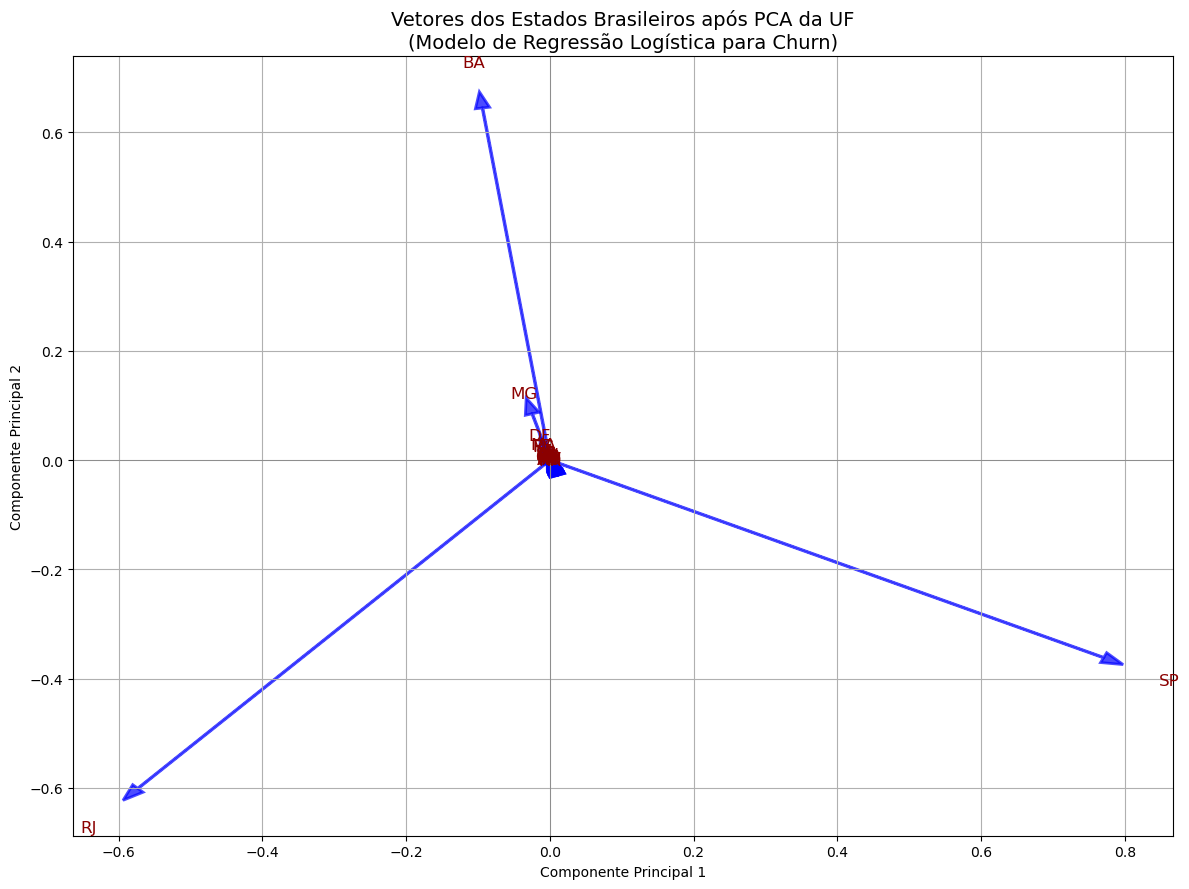

In [88]:
# Obter nomes das UFs codificadas (dummies)
ufs = uf_dummies.columns

# "component_vectors" traz o coeficiente (peso) de cada dummy UF nos PCs escolhidos
component_vectors = pca.components_.T  # shape: (num_UFs-1, num_components)

plt.figure(figsize=(12, 9))
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)

for i, uf in enumerate(ufs):
    plt.arrow(0, 0,
              component_vectors[i, 0], component_vectors[i, 1],
              color='blue', alpha=0.7, head_width=0.02, linewidth=2, length_includes_head=True)
    plt.text(component_vectors[i, 0]*1.08, component_vectors[i, 1]*1.08, uf,
             fontsize=12, color='darkred', ha='center', va='center')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Vetores dos Estados Brasileiros após PCA da UF\n(Modelo de Regressão Logística para Churn)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


A análise de PCA evidenciou que SP, RJ e BA possuem perfis de churn mais distintos e separado das demais que formam um grupo mais homogêneo quando observadas nos dois primeiros componentes principais.
Com isso, ao inves de usar os PCAs vou reagrupar as UFs de modo a ficar com as seguintes categorias: “SP”, “RJ”, “BA” e “Outros” (agrupando todos os demais estados)



In [89]:
# Refazer o modelo usando o agrupamento “SP”, “RJ”, “BA” e “Outros” com os dados de treino e depois aplicar em teste.

# Reagrupando as UFs
# Criar uma nova coluna com os grupos desejados
df_treino['grupo_UFs'] = df_treino['UF'].apply(lambda x: x if x in ['BA', 'RJ', 'SP'] else 'OUTRAS')

# Converter para tipo categórico (boas práticas para regressão com dummies)
df_treino['grupo_UFs'] = df_treino['grupo_UFs'].astype('category')


In [90]:
df_treino['grupo_UFs'].unique()

['OUTRAS', 'SP', 'RJ', 'BA']
Categories (4, object): ['BA', 'OUTRAS', 'RJ', 'SP']

In [91]:
# Rodar novamente a criação do modelo

# Refazendo o modelo com grupo_UFs no lugar de UF

# Seleciona as variáveis para o modelo
modelo_churn = df_treino[['CANCELADO_NUM', 'FAIXA_RENDA', 'SEXO', 'grupo_UFs',
                          'INADIMPLENTE', 'VALOR_MENSALIDADE',
                          'idadenaadesao_cat', 'qtdconsultas12m_cat']]

# Cópia explícita para evitar warning de SettingWithCopy
modelo_churn = modelo_churn.copy()

# Separar a variável resposta
y = modelo_churn['CANCELADO_NUM']

# Identifica colunas do tipo object e converte para category
obj_cols = modelo_churn.select_dtypes(include='object').columns
modelo_churn[obj_cols] = modelo_churn[obj_cols].astype('category')

# Cria dummies (com drop_first para evitar multicolinearidade perfeita)
X = pd.get_dummies(modelo_churn.drop(columns=['CANCELADO_NUM']), drop_first=True, dtype=np.int64)

# Adiciona constante ao modelo (termo independente)
X = sm.add_constant(X)

# Ajusta o modelo GLM com família binomial (logística)
modelo_churn = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# Exibe o resumo do modelo
print(modelo_churn.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          CANCELADO_NUM   No. Observations:                69365
Model:                            GLM   Df Residuals:                    69350
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21528.
Date:                Mon, 22 Sep 2025   Deviance:                       43056.
Time:                        21:57:11   Pearson chi2:                 7.03e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5201
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

MSE do modelo: 0.09121624914721166
RMSE do modelo: 0.3020202793641706
   threshold  precision    recall  accuracy  f1_score        ks      lift
0        0.1   0.826904  0.972752  0.864168  0.893918  0.747434  1.405493
1        0.2   0.841881  0.968586  0.874490  0.900800  0.747434  1.430950
2        0.3   0.856294  0.960598  0.881972  0.905452  0.747434  1.455448
3        0.4   0.865300  0.954692  0.885908  0.907801  0.747434  1.470756
4        0.5   0.869629  0.950625  0.887104  0.908325  0.747434  1.478113
5        0.6   0.870722  0.948150  0.886672  0.907788  0.747434  1.479971
6        0.7   0.878148  0.929748  0.882765  0.903211  0.747434  1.492593
7        0.8   0.920809  0.717716  0.797607  0.806676  0.747434  1.565104
8        0.9   0.968479  0.426881  0.654639  0.592571  0.747434  1.646129


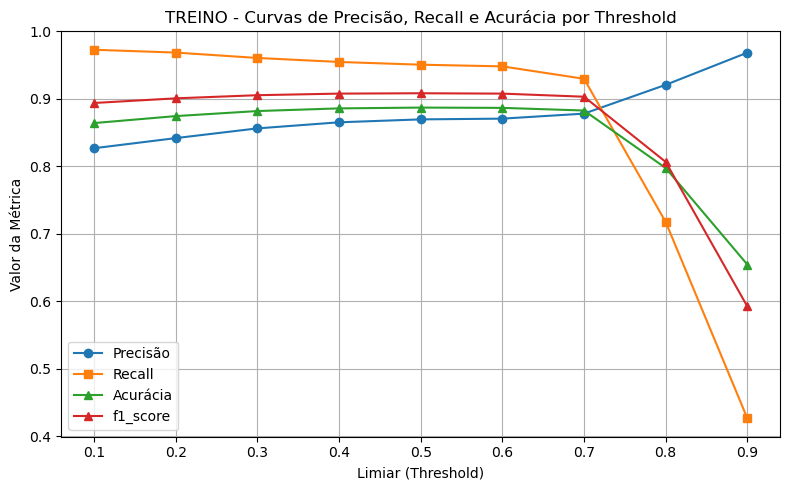

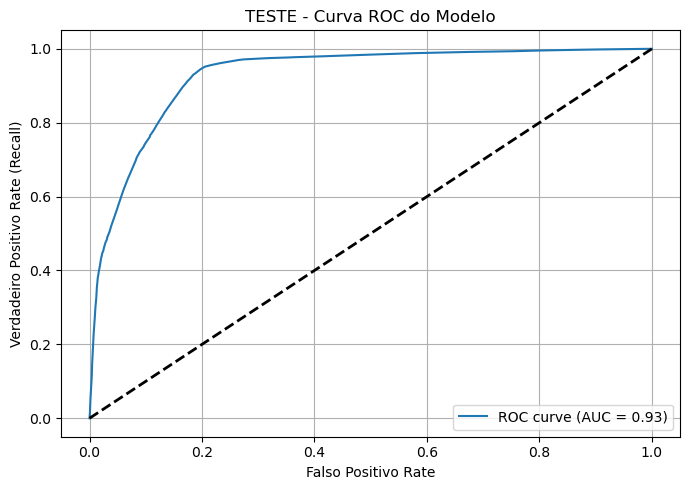

In [92]:
# Nova base (cópia dos dados de entrada do modelo)
churn_metricas = X.copy()  # matriz de variáveis independentes com dummies + constante

# previsões (valores ajustados/preditos pelo modelo)
y_chapeu = modelo_churn.predict(X)

# coluna de previsões à nova base
churn_metricas['y_chapeu'] = y_chapeu

# Se desejar, inclua o y real para facilitar análises
churn_metricas['CANCELADO_NUM'] = y.values

# criando as regras de decisão

# Para cada threshold de 0.1 a 0.9 (passo 0.1)
for t in np.arange(0.1, 1.0, 0.1):
    col_name = f'decisao_{str(round(t, 1)).replace(".", "_")}'
    churn_metricas[col_name] = np.where(churn_metricas['y_chapeu'] >= t, 1.0, 0.0)

#Calculando o MSE
churn_metricas['MSE'] = (churn_metricas['CANCELADO_NUM'] - churn_metricas['y_chapeu'])**2
MSE_modelo = churn_metricas['MSE'].mean()
print("MSE do modelo:", MSE_modelo)

#Calculando o RMSE
RMSE_modelo = np.sqrt(MSE_modelo)
print("RMSE do modelo:", RMSE_modelo)

y_true = churn_metricas['CANCELADO_NUM'].values
y_prob = churn_metricas['y_chapeu'].values
thresholds = np.arange(0.1, 1.0, 0.1)
results = []

# Função para calcular o KS
def kolmogorov_smirnov(y_true, y_prob):
    fpr, tpr, thresh = roc_curve(y_true, y_prob)
    return np.max(np.abs(tpr - fpr))

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # KS calcula-se sobre as probabilidades, não sobre threshold fixo – mas pode mostrar para cada corte
    ks = kolmogorov_smirnov(y_true, y_prob)

    # Lift no threshold
    # Proporção de positivos no grupo predito como 1 em relação à proporção total de positivos
    if sum(y_pred) > 0:
        lift = (y_true[y_pred == 1].mean()) / y_true.mean()
    else:
        lift = np.nan  # Evita divisão por zero

    results.append({
        'threshold': round(t,1),
        'precision': prec,
        'recall': rec,
        'accuracy': acc,
        'f1_score': f1,
        'ks': ks,
        'lift': lift,
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

plt.figure(figsize=(8,5))
plt.plot(metrics_df['threshold'], metrics_df['precision'], marker='o', label='Precisão')
plt.plot(metrics_df['threshold'], metrics_df['recall'], marker='s', label='Recall')
plt.plot(metrics_df['threshold'], metrics_df['accuracy'], marker='^', label='Acurácia')
plt.plot(metrics_df['threshold'], metrics_df['f1_score'], marker='^', label='f1_score')

plt.xlabel('Limiar (Threshold)')
plt.ylabel('Valor da Métrica')
plt.title('TREINO - Curvas de Precisão, Recall e Acurácia por Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Verdadeiro Positivo Rate (Recall)')
plt.title('TESTE - Curva ROC do Modelo')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()



In [93]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. Agrupar UFs
df_treino['grupo_UF'] = df_treino['UF'].apply(lambda x: x if x in ['BA', 'RJ', 'SP'] else 'OUTRAS')

# 2. Selecionar colunas relevantes para o modelo
colunas_modelo = [
    'CANCELADO_NUM',          # variável resposta (binária: 0 ou 1)
    'FAIXA_RENDA',            # categórica
    'SEXO',                   # categórica
    'grupo_UF',               # categórica agrupada
    'INADIMPLENTE',           # categórica
    'VALOR_MENSALIDADE',      # numérica ou categórica (ver abaixo)
    'idadenaadesao_cat',      # categórica
    'qtdconsultas12m_cat'     # categórica

]

modelo_churn = df_treino[colunas_modelo].copy()

# 3. Converter colunas do tipo 'object' para 'category'
colunas_objetct = modelo_churn.select_dtypes(include='object').columns
modelo_churn[colunas_objetct] = modelo_churn[colunas_objetct].astype('category')

# 4. Gerar variáveis dummies (com drop_first para evitar multicolinearidade)
modelo_churn_dummies = pd.get_dummies(
    modelo_churn.drop(columns=['CANCELADO_NUM']),  # exclui variável resposta
    drop_first=True,
    dtype=np.int64
)

# 5. Variáveis independentes (X) e dependente (y)
X = sm.add_constant(modelo_churn_dummies)
y = modelo_churn['CANCELADO_NUM']

# 6. Ajustar modelo de regressão logística
modelo_final = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# 7. Exibir o resumo
print(modelo_final.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          CANCELADO_NUM   No. Observations:                69365
Model:                            GLM   Df Residuals:                    69350
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21528.
Date:                Mon, 22 Sep 2025   Deviance:                       43056.
Time:                        21:57:12   Pearson chi2:                 7.03e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5201
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

MSE do modelo (teste): 0.2744233047540139
RMSE do modelo (teste): 0.5238542781671387
   threshold  precision    recall  accuracy  f1_score        ks      lift
0        0.1   0.588372  1.000000  0.588372  0.740849  0.385856  1.000000
1        0.2   0.588372  1.000000  0.588372  0.740849  0.385856  1.000000
2        0.3   0.588372  1.000000  0.588372  0.740849  0.385856  1.000000
3        0.4   0.588372  1.000000  0.588372  0.740849  0.385856  1.000000
4        0.5   0.588392  1.000000  0.588406  0.740865  0.385856  1.000034
5        0.6   0.592203  0.994625  0.593856  0.742386  0.385856  1.006511
6        0.7   0.629864  0.949677  0.642038  0.757394  0.385856  1.070521
7        0.8   0.717827  0.784983  0.691935  0.749904  0.385856  1.220022
8        0.9   0.848910  0.491908  0.649541  0.622882  0.385856  1.442811


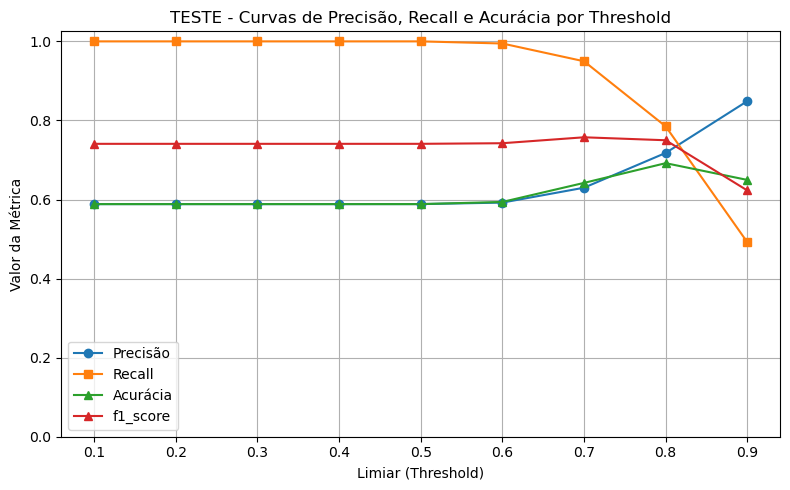

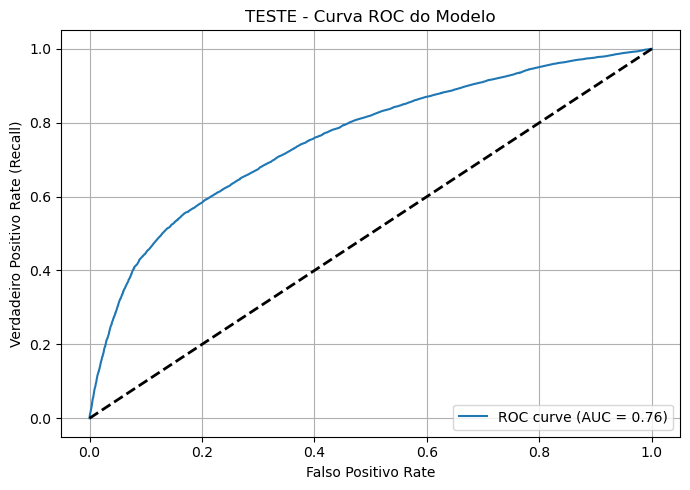

In [94]:
# Cópia dos dados de entrada do modelo (variáveis independentes)
churn_metricas_teste = X_teste.copy()

# Adiciona as previsões ao dataframe
churn_metricas_teste['y_chapeu'] = y_chapeu_teste

# Adiciona o y real da base de teste para facilitar análises
churn_metricas_teste['CANCELADO_NUM'] = y_teste.reset_index(drop=True).values

# criando as regras de decisão

# Criando colunas de decisão com diferentes thresholds de classificação
for t in np.arange(0.1, 1.0, 0.1):
    # Nome da nova coluna com o threshold aplicado
    col_name = f'decisao_{str(round(t, 1)).replace(".", "_")}'

    # Se a probabilidade prevista for maior ou igual ao threshold, classifica como 1 (cancelado)
    churn_metricas_teste[col_name] = np.where(churn_metricas_teste['y_chapeu'] >= t, 1.0, 0.0)
# Calculando o MSE entre o valor real (0 ou 1) e a probabilidade prevista (entre 0 e 1)
churn_metricas_teste['MSE'] = (churn_metricas_teste['CANCELADO_NUM'] - churn_metricas_teste['y_chapeu'])**2

# Média dos erros quadráticos (MSE)
MSE_modelo_teste = churn_metricas_teste['MSE'].mean()
print("MSE do modelo (teste):", MSE_modelo_teste)

# Raiz do MSE (RMSE) – interpretação no mesmo intervalo que y_chapeu
RMSE_modelo_teste = np.sqrt(MSE_modelo_teste)
print("RMSE do modelo (teste):", RMSE_modelo_teste)
y_true_teste = churn_metricas_teste['CANCELADO_NUM'].values
y_prob_teste = churn_metricas_teste['y_chapeu'].values
thresholds = np.arange(0.1, 1.0, 0.1)
results_teste = []

# Função para calcular o KS
def kolmogorov_smirnov(y_true, y_prob):
    fpr, tpr, thresh = roc_curve(y_true, y_prob)
    return np.max(np.abs(tpr - fpr))

for t in thresholds:
    y_pred_teste = (y_prob_teste >= t).astype(int)
    prec = precision_score(y_true_teste, y_pred_teste, zero_division=0)
    rec = recall_score(y_true_teste, y_pred_teste, zero_division=0)
    acc = accuracy_score(y_true_teste, y_pred_teste)
    f1 = f1_score(y_true_teste, y_pred_teste, zero_division=0)

    # KS calcula-se sobre as probabilidades, não sobre threshold fixo – mas pode mostrar para cada corte
    ks = kolmogorov_smirnov(y_true_teste, y_prob_teste)

    # Lift no threshold
    # Proporção de positivos no grupo predito como 1 em relação à proporção total de positivos
    if sum(y_pred_teste) > 0:
        lift = (y_true_teste[y_pred_teste == 1].mean()) / y_true_teste.mean()
    else:
        lift = np.nan  # Evita divisão por zero

    results_teste.append({
        'threshold': round(t,1),
        'precision': prec,
        'recall': rec,
        'accuracy': acc,
        'f1_score': f1,
        'ks': ks,
        'lift': lift,
    })

metrics_teste_df = pd.DataFrame(results_teste)
print(metrics_teste_df)
plt.figure(figsize=(8,5))
plt.plot(metrics_teste_df['threshold'], metrics_teste_df['precision'], marker='o', label='Precisão')
plt.plot(metrics_teste_df['threshold'], metrics_teste_df['recall'], marker='s', label='Recall')
plt.plot(metrics_teste_df['threshold'], metrics_teste_df['accuracy'], marker='^', label='Acurácia')
plt.plot(metrics_teste_df['threshold'], metrics_teste_df['f1_score'], marker='^', label='f1_score')

plt.xlabel('Limiar (Threshold)')
plt.ylabel('Valor da Métrica')
plt.title('TESTE - Curvas de Precisão, Recall e Acurácia por Threshold')
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_true_teste, y_prob_teste)
auc = roc_auc_score(y_true_teste, y_prob_teste)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Verdadeiro Positivo Rate (Recall)')
plt.title('TESTE - Curva ROC do Modelo')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


fim do modelo de churn